# Scraping, Transforming and Cleaning Chess Game data from 'Chess.com' for Analysis
__This project is to develop data cleaning skills in python__
<br>
- A successful project results in a dataset with logical columns, zero non-null values, no invalid or anamalous values, and a format which is easy to perform analysis on
- The project should also feature some ad-hoc analysis to demonstrate the successful scraping and cleaning. 

# Contents
[1. Scraping the Data](#1.-Scraping-the-Data-from-the-Chess.com-API) 
> Extract the data from the Chess.com API using the python 'requests' library; the data is technically "forbidden" which adds complexity to the process, and it is also partitioned so requires consolidation.

[2. Reading the Data](#2.-Reading-the-Data)
> Transform the data into a DataFrame. Then understand the information and plan how to clean it.

[3. Reading, Cleaning and Transforming the 'pgn' DataFrame](#3.-Reading,-Cleaning-and-Transforming-the-'pgn'-DataFrame)
> Create and clean a DataFrame called 'pgn_df' which contains all of the data from the 'pgn' column inside of the original 'df' DataFrame.

[4. Combining, Cleaning and Transforming the 'pgn_df' and 'df' DataFrames](#4.-Combining,-Cleaning-and-Transforming-the-'pgn_df'-and-'df'-DataFrames)
> Combine the two main DataFrames together, delete repetitive information and perform final transformations.

[5. Export to SQL Database](#5.-Export-to-SQL-Database)
> Use SQLAlchemy to create an engine to export the dataframes to SSMS

[6. Ad Hoc Analysis](#6.-Ad-Hoc-Analysis)
> Make this chart, that chart and those chart







In [207]:
import requests
import json
import pandas as pd
import re
import datetime
# import chess.pgn
# import chess.engine
import urllib.request
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<div style="background-color: cyan; padding: 20px;">
<h1>1. Scraping the Data from the Chess.com API</h1>
</div>

***
1) __Test to see if the website is responding.__
***

In [210]:
# check that the request is successful - 200 should be output
response = requests.get("https://api.chess.com/pub/player/kuzzonz/games/archives")
status = response.status_code
status

403

***
403 means the content is forbidden. Let's verify that the content is going to display incorrectly
***

In [212]:
content = response.content # should give me a list of archived games for each month since my account was made
content

b'<!DOCTYPE html><html lang="en-US"><head><title>Just a moment...</title><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta http-equiv="X-UA-Compatible" content="IE=Edge"><meta name="robots" content="noindex,nofollow"><meta name="viewport" content="width=device-width,initial-scale=1"><style>*{box-sizing:border-box;margin:0;padding:0}html{line-height:1.15;-webkit-text-size-adjust:100%;color:#313131;font-family:system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji}body{display:flex;flex-direction:column;height:100vh;min-height:100vh}.main-content{margin:8rem auto;max-width:60rem;padding-left:1.5rem}@media (width <= 720px){.main-content{margin-top:4rem}}.h2{font-size:1.5rem;font-weight:500;line-height:2.25rem}@media (width <= 720px){.h2{font-size:1.25rem;line-height:1.5rem}}#challenge-error-text{background-image:url();background-repeat:no-repeat;background

***
The content should be:
{"archives":["https://api.chess.com/pub/player/kuzzonz/games/2023/11","https://api.chess.com/pub/player/kuzzonz/games/2023/12","https://api.chess.com/pub/player/kuzzonz/games/2024/01","https://api.chess.com/pub/player/kuzzonz/games/2024/02","https://api.chess.com/pub/player/kuzzonz/games/2024/03","https://api.chess.com/pub/player/kuzzonz/games/2024/04","https://api.chess.com/pub/player/kuzzonz/games/2024/05","https://api.chess.com/pub/player/kuzzonz/games/2024/06","https://api.chess.com/pub/player/kuzzonz/games/2024/07","https://api.chess.com/pub/player/kuzzonz/games/2024/08","https://api.chess.com/pub/player/kuzzonz/games/2024/09"]}

The issue of the wrong content being output is likely due to Chess.com using a protection service like Cloudflare, which is preventing direct access to their API by intercepting the request with a security challenge. Instead of seeing a JSON response, we see HTML content from a Cloudflare challenge page.

2) __Bypass the forbidden content and verify the content is displaying correctly__
***

In [215]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0'
}
response = requests.get("https://api.chess.com/pub/player/kuzzonz/games/archives", headers=headers)

content = response.content # should give me a list of archived games for each month since my account was made
content


b'{"archives":["https://api.chess.com/pub/player/kuzzonz/games/2023/11","https://api.chess.com/pub/player/kuzzonz/games/2023/12","https://api.chess.com/pub/player/kuzzonz/games/2024/01","https://api.chess.com/pub/player/kuzzonz/games/2024/02","https://api.chess.com/pub/player/kuzzonz/games/2024/03","https://api.chess.com/pub/player/kuzzonz/games/2024/04","https://api.chess.com/pub/player/kuzzonz/games/2024/05","https://api.chess.com/pub/player/kuzzonz/games/2024/06","https://api.chess.com/pub/player/kuzzonz/games/2024/07","https://api.chess.com/pub/player/kuzzonz/games/2024/08","https://api.chess.com/pub/player/kuzzonz/games/2024/09","https://api.chess.com/pub/player/kuzzonz/games/2024/10","https://api.chess.com/pub/player/kuzzonz/games/2024/11"]}'

***
The content is displaying as expected.
***

In [217]:
# remove the b' from the start of the previous markdown cell
json_data = response.json()
json_data

{'archives': ['https://api.chess.com/pub/player/kuzzonz/games/2023/11',
  'https://api.chess.com/pub/player/kuzzonz/games/2023/12',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/01',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/02',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/03',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/04',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/05',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/06',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/07',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/08',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/09',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/10',
  'https://api.chess.com/pub/player/kuzzonz/games/2024/11']}

In [218]:
# all the game data is contained in 'archives'
archives = json_data["archives"]
archives

['https://api.chess.com/pub/player/kuzzonz/games/2023/11',
 'https://api.chess.com/pub/player/kuzzonz/games/2023/12',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/01',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/02',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/03',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/04',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/05',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/06',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/07',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/08',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/09',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/10',
 'https://api.chess.com/pub/player/kuzzonz/games/2024/11']

***
The archives consist of an api link that each contains information about chess games for a month. To access the games, we must repeat the process we used to scrape the data initially. First, we will do this for the first link. When that works, we will loop over all of the links.

3) __Repeat the process for one of the archive links__
***

In [220]:
# Define the URL as a variable
url = "https://api.chess.com/pub/player/kuzzonz/games/2023/11"

# Repeat the previous steps

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0'
}

response = requests.get(url, headers=headers)
content = response.content  # 
json_data = response.json()  
games = json_data["games"]   

games


[{'url': 'https://www.chess.com/game/live/94854608119',
  'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2023.11.27"]\n[Round "-"]\n[White "ali_lahroodi"]\n[Black "Kuzzonz"]\n[Result "0-1"]\n[CurrentPosition "8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -"]\n[Timezone "UTC"]\n[ECO "A00"]\n[ECOUrl "https://www.chess.com/openings/Polish-Opening-Bugayev-Attack"]\n[UTCDate "2023.11.27"]\n[UTCTime "20:08:03"]\n[WhiteElo "1555"]\n[BlackElo "1757"]\n[TimeControl "600"]\n[Termination "Kuzzonz won by resignation"]\n[StartTime "20:08:03"]\n[EndDate "2023.11.27"]\n[EndTime "20:19:34"]\n[Link "https://www.chess.com/game/live/94854608119"]\n\n1. a3 {[%clk 0:09:59.3]} 1... e5 {[%clk 0:09:54.6]} 2. b4 {[%clk 0:09:57.5]} 2... Nf6 {[%clk 0:09:50.7]} 3. Bb2 {[%clk 0:09:55.8]} 3... Bd6 {[%clk 0:09:42.1]} 4. h3 {[%clk 0:09:54.9]} 4... c6 {[%clk 0:09:36.8]} 5. g4 {[%clk 0:09:53.9]} 5... h6 {[%clk 0:09:32]} 6. Nf3 {[%clk 0:09:51.5]} 6... e4 {[%clk 0:09:17.5]} 7. Nd4 {[%clk 0:09:37.1]} 7... Be5 {[%clk 0:0

***
Although the information is hard to read, I have verified that it does contain information about every chess game that occurred during that month. Next, loop the same method over every url inside of 'archives' and combine the data together.

4. __Loop the process over every single link inside of 'archives'__ 
***

In [222]:
games_list = []

for url in archives:
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0'
    }
    response = requests.get(url, headers=headers)
    content = response.content  
    json_data = response.json()  
    games = json_data["games"]   
    games_list.extend(games)

print(games_list)

[{'url': 'https://www.chess.com/game/live/94854608119', 'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2023.11.27"]\n[Round "-"]\n[White "ali_lahroodi"]\n[Black "Kuzzonz"]\n[Result "0-1"]\n[CurrentPosition "8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -"]\n[Timezone "UTC"]\n[ECO "A00"]\n[ECOUrl "https://www.chess.com/openings/Polish-Opening-Bugayev-Attack"]\n[UTCDate "2023.11.27"]\n[UTCTime "20:08:03"]\n[WhiteElo "1555"]\n[BlackElo "1757"]\n[TimeControl "600"]\n[Termination "Kuzzonz won by resignation"]\n[StartTime "20:08:03"]\n[EndDate "2023.11.27"]\n[EndTime "20:19:34"]\n[Link "https://www.chess.com/game/live/94854608119"]\n\n1. a3 {[%clk 0:09:59.3]} 1... e5 {[%clk 0:09:54.6]} 2. b4 {[%clk 0:09:57.5]} 2... Nf6 {[%clk 0:09:50.7]} 3. Bb2 {[%clk 0:09:55.8]} 3... Bd6 {[%clk 0:09:42.1]} 4. h3 {[%clk 0:09:54.9]} 4... c6 {[%clk 0:09:36.8]} 5. g4 {[%clk 0:09:53.9]} 5... h6 {[%clk 0:09:32]} 6. Nf3 {[%clk 0:09:51.5]} 6... e4 {[%clk 0:09:17.5]} 7. Nd4 {[%clk 0:09:37.1]} 7... Be5 {[%clk 0:08:

<div style="background-color: navy; padding: 20px;">
<h1 style="color: white;">2. Reading the Data</h1>
<p style="color: white;"> Transform the data into a DataFrame and explore it. Then determine how to clean it.</p>
</div>

In [224]:
# pd.json_normalize() function flattens nested JSON data into a DataFrame
df = pd.json_normalize(games_list, sep='_', errors='raise') 
df

,url,pgn,time_control,end_time,rated,tcn,uuid,initial_setup,fen,time_class,rules,eco,white_rating,white_result,white_@id,white_username,white_uuid,black_rating,black_result,black_@id,black_username,black_uuid,accuracies_white,accuracies_black
0,https://www.chess.com/game/live/94854608119,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701116374,True,iq0Kjz!Tcj9RpxYQoE3VgvKCvBRKBQ5QjKQKbsZJlBKAfo...,aabd3f4d-8d60-11ee-b112-6cfe544c0428,,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,rapid,chess,https://www.chess.com/openings/Polish-Opening-...,1555,resigned,https://api.chess.com/pub/player/ali_lahroodi,ali_lahroodi,a4e4053a-33f7-11ec-a445-41efddde8c18,1757,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,NaN,NaN
1,https://www.chess.com/game/live/94855238653,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701117335,True,kA0Kbs!TowYQmCZRfo90lt6Sgm5ZnDZIDLSZjzIOiq8!eg...,49571800-8d62-11ee-b112-6cfe544c0428,,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -,rapid,chess,https://www.chess.com/openings/English-Opening...,1652,resigned,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,1799,win,https://api.chess.com/pub/player/janosik1913,Janosik1913,641e849c-98a3-11ec-803c-f1f069a24d7c,NaN,NaN
2,https://www.chess.com/game/live/94856363583,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701118129,True,mCYQnDZJCK6Lgv0SlBQIksIBvBLCbl5QlCQBdBJCBCWOcu...,89ff7492-8d64-11ee-b112-6cfe544c0428,,2K5/3R3p/1b2pp2/1Pk5/P4P2/8/8/8 w - -,rapid,chess,https://www.chess.com/openings/Caro-Kann-Defen...,1804,win,https://api.chess.com/pub/player/janosik1913,Janosik1913,641e849c-98a3-11ec-803c-f1f069a24d7c,1597,resigned,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,NaN,NaN
3,https://www.chess.com/game/live/94930258449,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701191959,True,kAZJAJ7JbsJGgv6EmC5Qfm86lt0SpxENclGPluPjsyjzul...,02e2cbff-8e11-11ee-b112-6cfe544c0428,,4k2r/R7/1p2p3/2n3p1/2Q5/7P/P5P1/6K1 b - -,rapid,chess,https://www.chess.com/openings/English-Opening...,1664,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,1564,resigned,https://api.chess.com/pub/player/bolotynchy,Bolotynchy,f71c736e-f3ab-11eb-a14c-5b26d531a2b8,NaN,NaN
4,https://www.chess.com/game/live/94930843383,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701192441,True,kA0SmCYIbs5Qow90fo!Tgm8!egZJAJSJCJQzmD2MDNTJsJ...,46d1bd3f-8e12-11ee-b112-6cfe544c0428,,r3qrk1/ppn1b1Qp/4b3/2p2p1N/6p1/1P4P1/P2P1PBP/R...,rapid,chess,https://www.chess.com/openings/Sicilian-Defens...,1720,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,1634,checkmated,https://api.chess.com/pub/player/jimi66,Jimi66,be1bb816-aaaf-11ec-9d28-35a625741001,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,https://www.chess.com/game/live/121895338013,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,1728156443,True,mCYQlBZJCK6LoELUnD3NDLU3ftNEdE!VcV2VKS?!EN!2gv...,5355c6d1-834f-11ef-94ee-6cfe544c0428,,r2k1b2/pp2pQ1b/B1pqP2p/3p1P2/3P4/8/PPP4P/RN2K1...,blitz,chess,https://www.chess.com/openings/Caro-Kann-Defen...,1334,win,https://api.chess.com/pub/player/csgaddy95,csgaddy95,df00f4a0-528c-11eb-b1e1-05f842d90c6c,1329,resigned,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,NaN,NaN
744,https://www.chess.com/game/live/121895381161,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,1728156623,True,gvYIpxXHmuZJfmWOlB0SBI9Ieg6Xks5ZjzIRiyHydy!TsA...,def779ab-834f-11ef-94ee-6cfe544c0428,,r3k2r/3n1ppp/p2bp3/q7/1PB5/2n1PP1P/5P2/R1B2RK1...,blitz,chess,https://www.chess.com/openings/Reti-Opening-Si...,1277,resigned,https://api.chess.com/pub/player/krechni,krechni,dde7cbca-6318-11ef-bd06-a79f521e6148,1336,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d

***
Initial observations: 
- The last 2 columns appear to be null
- 'pgn' column's data is unclear and needs further attention
***

In [226]:
df['pgn'][0] # explore the first record of the pgn column

'[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2023.11.27"]\n[Round "-"]\n[White "ali_lahroodi"]\n[Black "Kuzzonz"]\n[Result "0-1"]\n[CurrentPosition "8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -"]\n[Timezone "UTC"]\n[ECO "A00"]\n[ECOUrl "https://www.chess.com/openings/Polish-Opening-Bugayev-Attack"]\n[UTCDate "2023.11.27"]\n[UTCTime "20:08:03"]\n[WhiteElo "1555"]\n[BlackElo "1757"]\n[TimeControl "600"]\n[Termination "Kuzzonz won by resignation"]\n[StartTime "20:08:03"]\n[EndDate "2023.11.27"]\n[EndTime "20:19:34"]\n[Link "https://www.chess.com/game/live/94854608119"]\n\n1. a3 {[%clk 0:09:59.3]} 1... e5 {[%clk 0:09:54.6]} 2. b4 {[%clk 0:09:57.5]} 2... Nf6 {[%clk 0:09:50.7]} 3. Bb2 {[%clk 0:09:55.8]} 3... Bd6 {[%clk 0:09:42.1]} 4. h3 {[%clk 0:09:54.9]} 4... c6 {[%clk 0:09:36.8]} 5. g4 {[%clk 0:09:53.9]} 5... h6 {[%clk 0:09:32]} 6. Nf3 {[%clk 0:09:51.5]} 6... e4 {[%clk 0:09:17.5]} 7. Nd4 {[%clk 0:09:37.1]} 7... Be5 {[%clk 0:08:57.9]} 8. Nxc6 {[%clk 0:09:36.2]} 8... Nxc6 {[%clk 0:08:56.8]} 

***
- The 'pgn' column contains lots of information which should be converted into lots of columns.
- The best way to do this is to make another DataFrame called 'pgn_df' which will be cleaned and then combined with the original DataFrame.
- Furthermore, after about 20 'normal' columns, this DataFrame will contain hundreds of columns where each column will refer to each move within the game; observe how after the 'Link' column, there will be a column containing every move made as well as the time remaining for the rest of the game.
- The plan is to save all of that data as another DataFrame called 'moves_df' and then seperate the clock data into another DataFrame called 'moves_df_clock'. 

Next, let's explore the number of null and unique values in each df column as well as their data types.
***

In [229]:
summary_df = pd.DataFrame({
    'Total Rows': df.shape[0], # returns number of rows
    'Unique Values': df.nunique(), # returns number of unique values per column
    'Data Type': df.dtypes, # returns data type of each column
    'Null Values': df.isnull().sum() # returns sum of the number of null values per column
})
summary_df # consider adding .T attribute if you prefer to see the transposed version

,Total Rows,Unique Values,Data Type,Null Values
url,748,748,object,0
pgn,748,748,object,0
time_control,748,6,object,0
end_time,748,748,int64,0
rated,748,1,bool,0
tcn,748,747,object,0
uuid,748,748,object,0
initial_setup,748,1,object,0
fen,748,747,object,0
time_class,748,3,object,0


***
Important observations:
- 'accuracies_white' and 'accuracies_black' are predominantly null. It is most logical to drop these columns. However, it is worth briefly checking which values are non-null
    - are the non-null values in consecutive rows or randomly placed?
- 'rated', 'initial_setup' and 'rules' only have 1 unique value. These columns are therefore useless and should be dropped
- 'time_control', 'time_class', 'white_result' and 'black_result' contain a limited number of unique values which is expected. We should verify that these unique values are acceptable
- 'url', 'pgn', 'end_time' and 'uuid' are completely unique values and they should be.
-  'tcn' and 'fen' should be close to completely unique (they contain the moves of each game) and they are.
-  'eco' contains a large number of unique values which is expected (eco is a name/code assigned to each unique opening)
-  'white_rating' and 'black_rating' contain lots of unique values which is expected (chess ratings typically vary between 400 and 3000 so duplicates are expected)
-  'white_@id', 'white_username', 'white_uuid',  'black_@id', 'black_username' and 'black_uuid' contain roughly half unique values in relation to the number of rows which is expected because my game account 'Kuzzonz' is repeated in every single row once.

Next steps
1) Establish whether the non-null values in 'accuracies_white' and 'accuracies_black' are in consecutive rows or randomly placed
2) Drop the columns: 'rated', 'initial_setup' and 'rules'
3) Verify the integrity of the unique values in 'time_control', 'time_class', 'white_result' and 'black_result'

1. __Establish whether the non-null values in 'accuracies_white' and 'accuracies_black' are in consecutive rows or randomly placed__
***

Text(50.722222222222214, 0.5, 'Row Number')

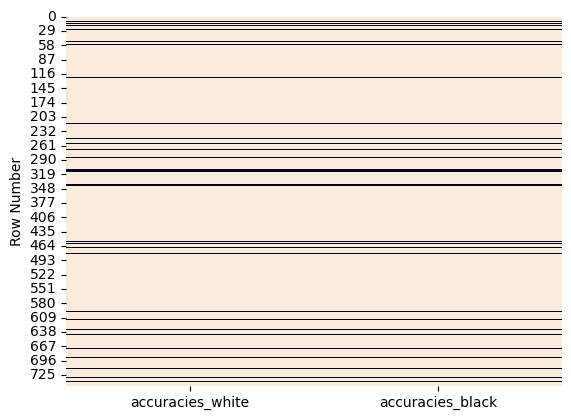

In [233]:
sns.heatmap(df[['accuracies_white', 'accuracies_black']].isnull(), cbar=False) # visualise the null's location
plt.ylabel('Row Number') # Set the label for the y-axis

***
The heatmap clearly shows that the location of the non-null values are completely random. This makes the data useless.

2. __Drop the columns: 'rated', 'initial_setup', 'rules', 'accuracies_white' and 'accuracies_black'__
***

In [235]:
df.drop(['rated', 'initial_setup', 'rules', 'accuracies_white', 'accuracies_black'], axis=1, inplace=True)
df

,url,pgn,time_control,end_time,tcn,uuid,fen,time_class,eco,white_rating,white_result,white_@id,white_username,white_uuid,black_rating,black_result,black_@id,black_username,black_uuid
0,https://www.chess.com/game/live/94854608119,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701116374,iq0Kjz!Tcj9RpxYQoE3VgvKCvBRKBQ5QjKQKbsZJlBKAfo...,aabd3f4d-8d60-11ee-b112-6cfe544c0428,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,rapid,https://www.chess.com/openings/Polish-Opening-...,1555,resigned,https://api.chess.com/pub/player/ali_lahroodi,ali_lahroodi,a4e4053a-33f7-11ec-a445-41efddde8c18,1757,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d
1,https://www.chess.com/game/live/94855238653,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701117335,kA0Kbs!TowYQmCZRfo90lt6Sgm5ZnDZIDLSZjzIOiq8!eg...,49571800-8d62-11ee-b112-6cfe544c0428,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -,rapid,https://www.chess.com/openings/English-Opening...,1652,resigned,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,1799,win,https://api.chess.com/pub/player/janosik1913,Janosik1913,641e849c-98a3-11ec-803c-f1f069a24d7c
2,https://www.chess.com/game/live/94856363583,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701118129,mCYQnDZJCK6Lgv0SlBQIksIBvBLCbl5QlCQBdBJCBCWOcu...,89ff7492-8d64-11ee-b112-6cfe544c0428,2K5/3R3p/1b2pp2/1Pk5/P4P2/8/8/8 w - -,rapid,https://www.chess.com/openings/Caro-Kann-Defen...,1804,win,https://api.chess.com/pub/player/janosik1913,Janosik1913,641e849c-98a3-11ec-803c-f1f069a24d7c,1597,resigned,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d
3,https://www.chess.com/game/live/94930258449,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701191959,kAZJAJ7JbsJGgv6EmC5Qfm86lt0SpxENclGPluPjsyjzul...,02e2cbff-8e11-11ee-b112-6cfe544c0428,4k2r/R7/1p2p3/2n3p1/2Q5/7P/P5P1/6K1 b - -,rapid,https://www.chess.com/openings/English-Opening...,1664,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,1564,resigned,https://api.chess.com/pub/player/bolotynchy,Bolotynchy,f71c736e-f3ab-11eb-a14c-5b26d531a2b8
4,https://www.chess.com/game/live/94930843383,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1701192441,kA0SmCYIbs5Qow90fo!Tgm8!egZJAJSJCJQzmD2MDNTJsJ...,46d1bd3f-8e12-11ee-b112-6cfe544c0428,r3qrk1/ppn1b1Qp/4b3/2p2p1N/6p1/1P4P1/P2P1PBP/R...,rapid,https://www.chess.com/openings/Sicilian-Defens...,1720,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,1634,checkmated,https://api.chess.com/pub/player/jimi66,Jimi66,be1bb816-aaaf-11ec-9d28-35a625741001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,https://www.chess.com/game/live/121895338013,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,1728156443,mCYQlBZJCK6LoELUnD3NDLU3ftNEdE!VcV2VKS?!EN!2gv...,5355c6d1-834f-11ef-94ee-6cfe544c0428,r2k1b2/pp2pQ1b/B1pqP2p/3p1P2/3P4/8/PPP4P/RN2K1...,blitz,https://www.chess.com/openings/Caro-Kann-Defen...,1334,win,https://api.chess.com/pub/player/csgaddy95,csgaddy95,df00f4a0-528c-11eb-b1e1-05f842d90c6c,1329,resigned,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d
744,https://www.chess.com/game/live/121895381161,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,1728156623,gvYIpxXHmuZJfmWOlB0SBI9Ieg6Xks5ZjzIRiyHydy!TsA...,def779ab-834f-11ef-94ee-6cfe544c0428,r3k2r/3n1ppp/p2bp3/q7/1PB5/2n1PP1P/5P2/R1B2RK1...,blitz,https://www.chess.com/openings/Reti-Opening-Si...,1277,resigned,https://api.chess.com/pub/player/krechni,krechni,dde7cbca-6318-11ef-bd06-a79f521e6148,1336,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d
745,https://www.chess.com/game/live/121895413647,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,1728157030,kA!Tbs0SmC9zowZJAJSJCJzsls7Jdv8!vJTJfoJPgm6EoX...,485cd34b-8350-11ef-94ee-6cfe544c

***
3. __Verify the integrity of the unique values in 'time_control', 'time_class', 'white_result' and 'black_result'__
***

In [237]:
cols = ['time_control', 'time_class', 'white_result', 'black_result']
for col in cols:
    print(col, " unique values: ", df[col].unique())

time_control  unique values:  ['600' '900+10' '180+2' '60' '60+1' '180']
time_class  unique values:  ['rapid' 'blitz' 'bullet']
white_result  unique values:  ['resigned' 'win' 'timeout' 'checkmated' 'repetition' 'abandoned' 'agreed'
 'stalemate' 'insufficient' 'timevsinsufficient']
black_result  unique values:  ['win' 'resigned' 'checkmated' 'abandoned' 'repetition' 'timeout' 'agreed'
 'stalemate' 'insufficient' 'timevsinsufficient']


***
The values are acceptable. 
Before we clean and transform this DataFrame, first we must clean and transform the 'pgn' column into a DataFrame called 'pgn_df' and then concatenate 'pgn_df' and 'df' together in case there is repeated data - otherwise we would clean columns that will be dropped due to repetition anyway.
***

<div style="background-color: lime; padding: 20px;">
<h1 style="color: black;">3. Reading, Cleaning and Transforming the 'pgn' DataFrame</h1>
<p style="color: black;">In addition, creating 'moves_df' and 'moves_clock_df'</p>
</div>

***
1) __Create 'pgn_df' from the 'pgn' column inside the original 'df'. Then drop the 'pgn' column from the original 'df' now we have exported the content. Explore the first element to learn how to clean it.__
***

In [241]:
# Create pgn_df
pgn_df = df['pgn']
df.drop(['pgn'], axis=1, inplace=True) # drop the 'pgn' column from original DataFrame

# Explore the first element to see what we will be dealing with
pgn_df[0]

'[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2023.11.27"]\n[Round "-"]\n[White "ali_lahroodi"]\n[Black "Kuzzonz"]\n[Result "0-1"]\n[CurrentPosition "8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -"]\n[Timezone "UTC"]\n[ECO "A00"]\n[ECOUrl "https://www.chess.com/openings/Polish-Opening-Bugayev-Attack"]\n[UTCDate "2023.11.27"]\n[UTCTime "20:08:03"]\n[WhiteElo "1555"]\n[BlackElo "1757"]\n[TimeControl "600"]\n[Termination "Kuzzonz won by resignation"]\n[StartTime "20:08:03"]\n[EndDate "2023.11.27"]\n[EndTime "20:19:34"]\n[Link "https://www.chess.com/game/live/94854608119"]\n\n1. a3 {[%clk 0:09:59.3]} 1... e5 {[%clk 0:09:54.6]} 2. b4 {[%clk 0:09:57.5]} 2... Nf6 {[%clk 0:09:50.7]} 3. Bb2 {[%clk 0:09:55.8]} 3... Bd6 {[%clk 0:09:42.1]} 4. h3 {[%clk 0:09:54.9]} 4... c6 {[%clk 0:09:36.8]} 5. g4 {[%clk 0:09:53.9]} 5... h6 {[%clk 0:09:32]} 6. Nf3 {[%clk 0:09:51.5]} 6... e4 {[%clk 0:09:17.5]} 7. Nd4 {[%clk 0:09:37.1]} 7... Be5 {[%clk 0:08:57.9]} 8. Nxc6 {[%clk 0:09:36.2]} 8... Nxc6 {[%clk 0:08:56.8]} 

***
2.  __Currently there are no columns and pgn_df is actually just a series. To transform the series into a DataFrame we have to split the data into columns. By exploring the first element, we can see that each block of data is stored inside square brackets so let's create columns by using a ']' delimiter.__ 
***

In [243]:
# split the series into new columns using ']'
pgn_df = pgn_df.str.split(']', expand=True)
print("(rows, columns): ", pgn_df.shape)
pgn_df.iloc[:, 0:23]

(rows, columns):  (748, 268)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""ali_lahroodi""","\n[Black ""Kuzzonz""","\n[Result ""0-1""","\n[CurrentPosition ""8/P4p2/3k2p1/5b2/3P1P2/8/5...","\n[Timezone ""UTC""","\n[ECO ""A00""","\n[ECOUrl ""https://www.chess.com/openings/Poli...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:08:03""","\n[WhiteElo ""1555""","\n[BlackElo ""1757""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by resignation""","\n[StartTime ""20:08:03""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:19:34""","\n[Link ""https://www.chess.com/game/live/94854...",\n\n1. a3 {[%clk 0:09:59.3,} 1... e5 {[%clk 0:09:54.6
1,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Janosik1913""","\n[Result ""0-1""","\n[CurrentPosition ""8/8/8/1p2p3/p7/4kp2/8/4K3 ...","\n[Timezone ""UTC""","\n[ECO ""A23""","\n[ECOUrl ""https://www.chess.com/openings/Engl...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:19:25""","\n[WhiteElo ""1652""","\n[BlackElo ""1799""","\n[TimeControl ""600""","\n[Termination ""Janosik1913 won by resignation""","\n[StartTime ""20:19:25""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:35:35""","\n[Link ""https://www.chess.com/game/live/94855...",\n\n1. c4 {[%clk 0:10:00,} 1... e5 {[%clk 0:09:57.6
2,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""Janosik1913""","\n[Black ""Kuzzonz""","\n[Result ""1-0""","\n[CurrentPosition ""2K5/3R3p/1b2pp2/1Pk5/P4P2/...","\n[Timezone ""UTC""","\n[ECO ""B10""","\n[ECOUrl ""https://www.chess.com/openings/Caro...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:35:38""","\n[WhiteElo ""1804""","\n[BlackElo ""1597""","\n[TimeControl ""600""","\n[Termination ""Janosik1913 won by resignation""","\n[StartTime ""20:35:38""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:48:49""","\n[Link ""https://www.chess.com/game/live/94856...",\n\n1. e4 {[%clk 0:09:56,} 1... c6 {[%clk 0:09:59.2
3,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.28""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Bolotynchy""","\n[Result ""1-0""","\n[CurrentPosition ""4k2r/R7/1p2p3/2n3p1/2Q5/7P...","\n[Timezone ""UTC""","\n[ECO ""A10""","\n[ECOUrl ""https://www.chess.com/openings/Engl...","\n[UTCDate ""2023.11.28""","\n[UTCTime ""17:10:20""","\n[WhiteElo ""1664""","\n[BlackElo ""1564""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by resignation""","\n[StartTime ""17:10:20""","\n[EndDate ""2023.11.28""","\n[EndTime ""17:19:19""","\n[Link ""https://www.chess.com/game/live/94930...",\n\n1. c4 {[%clk 0:09:59.3,} 1... d5 {[%clk 0:09:59.9
4,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.28""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Jimi66""","\n[Result ""1-0""","\n[CurrentPosition ""r3qrk1/ppn1b1Qp/4b3/2p2p1N...","\n[Timezone ""UTC""","\n[ECO ""B20""","\n[ECOUrl ""https://www.chess.com/openings/Sici...","\n[UTCDate ""2023.11.28""","\n[UTCTime ""17:19:23""","\n[WhiteElo ""1720""","\n[BlackElo ""1634""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by checkmate""","\n[StartTime ""17:19:23""","\n[EndDate ""2023.11.28""","\n[EndTime ""17:27:21""","\n[Link ""https://www.chess.com/game/live/94930...",\n\n1. c4 {[%clk 0:10:00,} 1... e6 {[%clk 0:09:51.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2024.10.05""","\n[Round ""-""","\n[White ""csgaddy95""","\n[Black ""Kuzzonz""","\n[Result ""1-0""","\n[CurrentPosition ""r2k1b2/pp2pQ1b/B1pqP2p/3p1...","\n[Timezone ""UTC""","\n[ECO ""B12""","\n[ECOUrl ""https://www.chess.com/openings/Caro...","\n[UTCDate ""2024.10.05""","\n[UTCTime ""19:23:39""","\n[WhiteElo ""1334""","\n[BlackElo ""1329""","\n[TimeControl ""180+2""","\n[Termination ""csgaddy95 won by resignation""","\n[StartTime ""19:2

***
As expected, there are hundreds of columns (268) and the same number of rows as our original DataFrame (df). Most of these columns refer to information about each move. However, the first few columns (0:21) contain essential information.

3) __Transform the data so that each column has a title__
***

In [245]:
# extract titles from the first row
titles = pgn_df.iloc[0, :] # get the first row
titles = titles.str.extract(pat="\[(.*?)\"", expand=False).str.strip().str.lower() #regex identify strings and remove trailing spaces
titles_list = list(titles) # form a list of the titles
titles_list = titles_list[0:21] # include up to the moves record section
# print("titles_list", titles_list, '\n') # print to check the list is correct


# create a dictionary with keys starting from 0 and increasing by 1
mapper = {i: titles_list[i] for i in range(len(titles_list))}

# print the dictionary
# print("mapper", mapper) # print mapper to confirm it is as expected


# rename the columns
pgn_df = pgn_df.rename(mapper=mapper, axis=1)
pgn_df = pgn_df.reset_index(drop=True) # reset the index - not necessary but avoids potential errors
pgn_df.iloc[:, 0: 23]


<>:3: SyntaxWarning: invalid escape sequence '\['
<>:3: SyntaxWarning: invalid escape sequence '\['
C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\4292471383.py:3: SyntaxWarning: invalid escape sequence '\['
  titles = titles.str.extract(pat="\[(.*?)\"", expand=False).str.strip().str.lower() #regex identify strings and remove trailing spaces


,event,site,date,round,white,black,result,currentposition,timezone,eco,ecourl,utcdate,utctime,whiteelo,blackelo,timecontrol,termination,starttime,enddate,endtime,link,21,22
0,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""ali_lahroodi""","\n[Black ""Kuzzonz""","\n[Result ""0-1""","\n[CurrentPosition ""8/P4p2/3k2p1/5b2/3P1P2/8/5...","\n[Timezone ""UTC""","\n[ECO ""A00""","\n[ECOUrl ""https://www.chess.com/openings/Poli...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:08:03""","\n[WhiteElo ""1555""","\n[BlackElo ""1757""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by resignation""","\n[StartTime ""20:08:03""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:19:34""","\n[Link ""https://www.chess.com/game/live/94854...",\n\n1. a3 {[%clk 0:09:59.3,} 1... e5 {[%clk 0:09:54.6
1,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Janosik1913""","\n[Result ""0-1""","\n[CurrentPosition ""8/8/8/1p2p3/p7/4kp2/8/4K3 ...","\n[Timezone ""UTC""","\n[ECO ""A23""","\n[ECOUrl ""https://www.chess.com/openings/Engl...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:19:25""","\n[WhiteElo ""1652""","\n[BlackElo ""1799""","\n[TimeControl ""600""","\n[Termination ""Janosik1913 won by resignation""","\n[StartTime ""20:19:25""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:35:35""","\n[Link ""https://www.chess.com/game/live/94855...",\n\n1. c4 {[%clk 0:10:00,} 1... e5 {[%clk 0:09:57.6
2,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""Janosik1913""","\n[Black ""Kuzzonz""","\n[Result ""1-0""","\n[CurrentPosition ""2K5/3R3p/1b2pp2/1Pk5/P4P2/...","\n[Timezone ""UTC""","\n[ECO ""B10""","\n[ECOUrl ""https://www.chess.com/openings/Caro...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:35:38""","\n[WhiteElo ""1804""","\n[BlackElo ""1597""","\n[TimeControl ""600""","\n[Termination ""Janosik1913 won by resignation""","\n[StartTime ""20:35:38""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:48:49""","\n[Link ""https://www.chess.com/game/live/94856...",\n\n1. e4 {[%clk 0:09:56,} 1... c6 {[%clk 0:09:59.2
3,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.28""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Bolotynchy""","\n[Result ""1-0""","\n[CurrentPosition ""4k2r/R7/1p2p3/2n3p1/2Q5/7P...","\n[Timezone ""UTC""","\n[ECO ""A10""","\n[ECOUrl ""https://www.chess.com/openings/Engl...","\n[UTCDate ""2023.11.28""","\n[UTCTime ""17:10:20""","\n[WhiteElo ""1664""","\n[BlackElo ""1564""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by resignation""","\n[StartTime ""17:10:20""","\n[EndDate ""2023.11.28""","\n[EndTime ""17:19:19""","\n[Link ""https://www.chess.com/game/live/94930...",\n\n1. c4 {[%clk 0:09:59.3,} 1... d5 {[%clk 0:09:59.9
4,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.28""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Jimi66""","\n[Result ""1-0""","\n[CurrentPosition ""r3qrk1/ppn1b1Qp/4b3/2p2p1N...","\n[Timezone ""UTC""","\n[ECO ""B20""","\n[ECOUrl ""https://www.chess.com/openings/Sici...","\n[UTCDate ""2023.11.28""","\n[UTCTime ""17:19:23""","\n[WhiteElo ""1720""","\n[BlackElo ""1634""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by checkmate""","\n[StartTime ""17:19:23""","\n[EndDate ""2023.11.28""","\n[EndTime ""17:27:21""","\n[Link ""https://www.chess.com/game/live/94930...",\n\n1. c4 {[%clk 0:10:00,} 1... e6 {[%clk 0:09:51.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2024.10.05""","\n[Round ""-""","\n[White ""csgaddy95""","\n[Black ""Kuzzonz""","\n[Result ""1-0""","\n[CurrentPosition ""r2k1b2/pp2pQ1b/B1pqP2p/3p1...","\n[Timezone ""UTC""","\n[ECO ""B12""","\n[ECOUrl ""https://www.chess.com/openings/Caro...","\n[UTCDate ""2024.10.05""","\n[UTCTime ""19:23:39""","\n[WhiteElo ""1334""","\n[Bla

***
4. __Make 'pgn_df' contain only information up to the 'link' column. Export all data to the right side of that to 'moves_df'.__
***

In [247]:
moves_df = pgn_df.copy()
pgn_df = pgn_df.iloc[:, 0: 21]
moves_df = moves_df.iloc[:, 21:]
pgn_df.head(5)

,event,site,date,round,white,black,result,currentposition,timezone,eco,ecourl,utcdate,utctime,whiteelo,blackelo,timecontrol,termination,starttime,enddate,endtime,link
0,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""ali_lahroodi""","\n[Black ""Kuzzonz""","\n[Result ""0-1""","\n[CurrentPosition ""8/P4p2/3k2p1/5b2/3P1P2/8/5...","\n[Timezone ""UTC""","\n[ECO ""A00""","\n[ECOUrl ""https://www.chess.com/openings/Poli...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:08:03""","\n[WhiteElo ""1555""","\n[BlackElo ""1757""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by resignation""","\n[StartTime ""20:08:03""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:19:34""","\n[Link ""https://www.chess.com/game/live/94854..."
1,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Janosik1913""","\n[Result ""0-1""","\n[CurrentPosition ""8/8/8/1p2p3/p7/4kp2/8/4K3 ...","\n[Timezone ""UTC""","\n[ECO ""A23""","\n[ECOUrl ""https://www.chess.com/openings/Engl...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:19:25""","\n[WhiteElo ""1652""","\n[BlackElo ""1799""","\n[TimeControl ""600""","\n[Termination ""Janosik1913 won by resignation""","\n[StartTime ""20:19:25""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:35:35""","\n[Link ""https://www.chess.com/game/live/94855..."
2,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.27""","\n[Round ""-""","\n[White ""Janosik1913""","\n[Black ""Kuzzonz""","\n[Result ""1-0""","\n[CurrentPosition ""2K5/3R3p/1b2pp2/1Pk5/P4P2/...","\n[Timezone ""UTC""","\n[ECO ""B10""","\n[ECOUrl ""https://www.chess.com/openings/Caro...","\n[UTCDate ""2023.11.27""","\n[UTCTime ""20:35:38""","\n[WhiteElo ""1804""","\n[BlackElo ""1597""","\n[TimeControl ""600""","\n[Termination ""Janosik1913 won by resignation""","\n[StartTime ""20:35:38""","\n[EndDate ""2023.11.27""","\n[EndTime ""20:48:49""","\n[Link ""https://www.chess.com/game/live/94856..."
3,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.28""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Bolotynchy""","\n[Result ""1-0""","\n[CurrentPosition ""4k2r/R7/1p2p3/2n3p1/2Q5/7P...","\n[Timezone ""UTC""","\n[ECO ""A10""","\n[ECOUrl ""https://www.chess.com/openings/Engl...","\n[UTCDate ""2023.11.28""","\n[UTCTime ""17:10:20""","\n[WhiteElo ""1664""","\n[BlackElo ""1564""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by resignation""","\n[StartTime ""17:10:20""","\n[EndDate ""2023.11.28""","\n[EndTime ""17:19:19""","\n[Link ""https://www.chess.com/game/live/94930..."
4,"[Event ""Live Chess""","\n[Site ""Chess.com""","\n[Date ""2023.11.28""","\n[Round ""-""","\n[White ""Kuzzonz""","\n[Black ""Jimi66""","\n[Result ""1-0""","\n[CurrentPosition ""r3qrk1/ppn1b1Qp/4b3/2p2p1N...","\n[Timezone ""UTC""","\n[ECO ""B20""","\n[ECOUrl ""https://www.chess.com/openings/Sici...","\n[UTCDate ""2023.11.28""","\n[UTCTime ""17:19:23""","\n[WhiteElo ""1720""","\n[BlackElo ""1634""","\n[TimeControl ""600""","\n[Termination ""Kuzzonz won by checkmate""","\n[StartTime ""17:19:23""","\n[EndDate ""2023.11.28""","\n[EndTime ""17:27:21""","\n[Link ""https://www.chess.com/game/live/94930..."


In [248]:
moves_df.head(5)

,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267
0,\n\n1. a3 {[%clk 0:09:59.3,} 1... e5 {[%clk 0:09:54.6,} 2. b4 {[%clk 0:09:57.5,} 2... Nf6 {[%clk 0:09:50.7,} 3. Bb2 {[%clk 0:09:55.8,} 3... Bd6 {[%clk 0:09:42.1,} 4. h3 {[%clk 0:09:54.9,} 4... c6 {[%clk 0:09:36.8,} 5. g4 {[%clk 0:09:53.9,} 5... h6 {[%clk 0:09:32,} 6. Nf3 {[%clk 0:09:51.5,} 6... e4 {[%clk 0:09:17.5,} 7. Nd4 {[%clk 0:09:37.1,} 7... Be5 {[%clk 0:08:57.9,} 8. Nxc6 {[%clk 0:09:36.2,} 8... Nxc6 {[%clk 0:08:56.8,} 9. Bxe5 {[%clk 0:09:34.1,} 9... Nxe5 {[%clk 0:08:55.1,} 10. Nc3 {[%clk 0:09:31.5,} 10... d5 {[%clk 0:08:48.1,} 11. d4 {[%clk 0:09:11.1,} 11... Nc4 {[%clk 0:08:23.7,} 12. Bg2 {[%clk 0:09:06.8,} 12... Be6 {[%clk 0:08:15.8,} 13. f4 {[%clk 0:08:54.9,} 13... Ne3 {[%clk 0:08:05.1,} 14. Qd2 {[%clk 0:08:13.9,} 14... Nxg2+ {[%clk 0:08:03.2,} 15. Kf2 {[%clk 0:08:13.1,} 15... e3+ {[%clk 0:08:02.2,} 16. Qxe3 {[%clk 0:08:09.2,} 16... Nxe3 {[%clk 0:08:01,} 17. Kxe3 {[%clk 0:08:09.1,} 17... Nxg4+ {[%clk 0:07:57.3,} 18. hxg4 {[%clk 0:08:07.4,} 18... Bxg4 {[%clk 0:07:56.2,} 19. Kd2 {[%clk 0:08:00.7,} 19... O-O {[%clk 0:07:48.6,} 20. Rhg1 {[%clk 0:07:55.1,} 20... h5 {[%clk 0:07:20.2,} 21. Rg2 {[%clk 0:07:49,} 21... Re8 {[%clk 0:07:18.5,} 22. Rh1 {[%clk 0:07:45.1,} 22... Qb6 {[%clk 0:07:16.7,} 23. e3 {[%clk 0:07:39.4,} 23... Rac8 {[%clk 0:07:06.7,} 24. Nxd5 {[%clk 0:07:32.8,} 24... Qg6 {[%clk 0:06:54,} 25. Kc1 {[%clk 0:07:05,} 25... Qe4 {[%clk 0:06:47.1,} 26. Nf6+ {[%clk 0:06:48.9,} 26... Kf8 {[%clk 0:06:45.3,} 27. Nxe4 {[%clk 0:05:58.4,} 27... Rxe4 {[%clk 0:06:45.2,} 28. Rg3 {[%clk 0:05:48.4,} 28... Rc3 {[%clk 0:06:37.1,} 29. Kb2 {[%clk 0:05:42.4,} 29... Rcxe3 {[%clk 0:06:34.8,} 30. Rxe3 {[%clk 0:05:41.5,} 30... Rxe3 {[%clk 0:06:33.3,} 31. Rh2 {[%clk 0:05:20.6,} 31... b5 {[%clk 0:06:30,} 32. c3 {[%clk 0:05:10.4,} 32... g6 {[%clk 0:06:28.5,} 33. Kb3 {[%clk 0:05:08.1,} 33... Be6+ {[%clk 0:06:25,} 34. Kc2 {[%clk 0:05:04.3,} 34... Ke7 {[%clk 0:06:22.2,} 35. Kd2 {[%clk 0:05:02.8,} 35... Rg3 {[%clk 0:06:15.8,} 36. Rh4 {[%clk 0:04:58.2,} 36... Kd6 {[%clk 0:06:13.2,} 37. Kc2 {[%clk 0:04:29.7,} 37... Rg2+ {[%clk 0:06:07.5,} 38. Kd3 {[%clk 0:04:26.1,} 38... Bf5+ {[%clk 0:06:06.6,} 39. Ke3 {[%clk 0:04:19.2,} 39... Ra2 {[%clk 0:06:05.2,} 40. Rh1 {[%clk 0:03:57.8,} 40... Rxa3 {[%clk 0:06:01.7,} 41. Rc1 {[%clk 0:03:57,} 41... a6 {[%clk 0:05:57.7,} 42. Kd2 {[%clk 0:03:48.6,} 42... Ra2+ {[%clk 0:05:54.1,} 43. Ke1 {[%clk 0:03:46.6,} 43... Rh2 {[%clk 0:05:51,} 44. c4 {[%clk 0:03:44.9,} 44... Rh1+ {[%clk 0:05:49,} 45. Kd2 {[%clk 0:03:44,} 45... Rxc1 {[%clk 0:05:48.1,} 46. Kxc1 {[%clk 0:03:41.9,} 46... bxc4 {[%clk 0:05:47.3,} 47. Kd2 {[%clk 0:03:41,} 47... h4 {[%clk 0:05:43.4,} 48. Ke3 {[%clk 0:03:40.2,} 48... h3 {[%clk 0:05:42.5,} 49. Kf2 {[%clk 0:03:39.4,} 49... c3 {[%clk 0:05:41.7,} 50. Ke3 {[%clk 0:03:36,} 50... h2 {[%clk 0:05:39.8,} 51. b5 {[%clk 0:03:33.6,} 51... h1=Q {[%clk 0:05:36.7,} 52. bxa6 {[%clk 0:03:31.1,} 52... c2 {[%clk 0:05:32.5,} 53. a7 {[%clk 0:03:29.2,} 53... c1=Q+ {[%clk 0:05:30.9,} 54. Kf2 {[%clk 0:03:27.6,} 0-1\n,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N

***
5. __Transform each row of 'pgn_df' so that it does not contain repetitive information. E.g. row index 2 will be called 'Date' and each row will just contain the date itself, not '\n[Date "2024.09.16"'__
***

In [250]:
# create a regular expression pattern to match text inside quotation marks
pattern = r'"(.*?)"'

# apply the regular expression to columns in the range [0:21] using applymap
pgn_df = pgn_df.map(lambda x: re.search(pattern, str(x)).group(1) if isinstance(x, str) and re.search(pattern, str(x)) else None)

pgn_df.head(5)

,event,site,date,round,white,black,result,currentposition,timezone,eco,ecourl,utcdate,utctime,whiteelo,blackelo,timecontrol,termination,starttime,enddate,endtime,link
0,Live Chess,Chess.com,2023.11.27,-,ali_lahroodi,Kuzzonz,0-1,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,UTC,A00,https://www.chess.com/openings/Polish-Opening-...,2023.11.27,20:08:03,1555,1757,600,Kuzzonz won by resignation,20:08:03,2023.11.27,20:19:34,https://www.chess.com/game/live/94854608119
1,Live Chess,Chess.com,2023.11.27,-,Kuzzonz,Janosik1913,0-1,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -,UTC,A23,https://www.chess.com/openings/English-Opening...,2023.11.27,20:19:25,1652,1799,600,Janosik1913 won by resignation,20:19:25,2023.11.27,20:35:35,https://www.chess.com/game/live/94855238653
2,Live Chess,Chess.com,2023.11.27,-,Janosik1913,Kuzzonz,1-0,2K5/3R3p/1b2pp2/1Pk5/P4P2/8/8/8 w - -,UTC,B10,https://www.chess.com/openings/Caro-Kann-Defen...,2023.11.27,20:35:38,1804,1597,600,Janosik1913 won by resignation,20:35:38,2023.11.27,20:48:49,https://www.chess.com/game/live/94856363583
3,Live Chess,Chess.com,2023.11.28,-,Kuzzonz,Bolotynchy,1-0,4k2r/R7/1p2p3/2n3p1/2Q5/7P/P5P1/6K1 b - -,UTC,A10,https://www.chess.com/openings/English-Opening...,2023.11.28,17:10:20,1664,1564,600,Kuzzonz won by resignation,17:10:20,2023.11.28,17:19:19,https://www.chess.com/game/live/94930258449
4,Live Chess,Chess.com,2023.11.28,-,Kuzzonz,Jimi66,1-0,r3qrk1/ppn1b1Qp/4b3/2p2p1N/6p1/1P4P1/P2P1PBP/R...,UTC,B20,https://www.chess.com/openings/Sicilian-Defens...,2023.11.28,17:19:23,1720,1634,600,Kuzzonz won by checkmate,17:19:23,2023.11.28,17:27:21,https://www.chess.com/game/live/94930843383


***
'pgn_df' is now clean. Let's clean 'moves_df'.

6.  __The objective is make each cell of 'moves_df' contain the move, and each column be named after the move number. E.g. The first 4 columns will be "1.", "1...", "2.", "2...".__

The first column data all contain a redundant "\n\n" at the start which must be removed. All subsequent columns contain a redundant "} " (remember the trailing space) which must be removed.
***

In [252]:
moves_df.iloc[:,0] = moves_df.iloc[:,0].str.replace("\n\n","") # reason for iloc is so .str method works
moves_df.head(5)

,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267
0,1. a3 {[%clk 0:09:59.3,} 1... e5 {[%clk 0:09:54.6,} 2. b4 {[%clk 0:09:57.5,} 2... Nf6 {[%clk 0:09:50.7,} 3. Bb2 {[%clk 0:09:55.8,} 3... Bd6 {[%clk 0:09:42.1,} 4. h3 {[%clk 0:09:54.9,} 4... c6 {[%clk 0:09:36.8,} 5. g4 {[%clk 0:09:53.9,} 5... h6 {[%clk 0:09:32,} 6. Nf3 {[%clk 0:09:51.5,} 6... e4 {[%clk 0:09:17.5,} 7. Nd4 {[%clk 0:09:37.1,} 7... Be5 {[%clk 0:08:57.9,} 8. Nxc6 {[%clk 0:09:36.2,} 8... Nxc6 {[%clk 0:08:56.8,} 9. Bxe5 {[%clk 0:09:34.1,} 9... Nxe5 {[%clk 0:08:55.1,} 10. Nc3 {[%clk 0:09:31.5,} 10... d5 {[%clk 0:08:48.1,} 11. d4 {[%clk 0:09:11.1,} 11... Nc4 {[%clk 0:08:23.7,} 12. Bg2 {[%clk 0:09:06.8,} 12... Be6 {[%clk 0:08:15.8,} 13. f4 {[%clk 0:08:54.9,} 13... Ne3 {[%clk 0:08:05.1,} 14. Qd2 {[%clk 0:08:13.9,} 14... Nxg2+ {[%clk 0:08:03.2,} 15. Kf2 {[%clk 0:08:13.1,} 15... e3+ {[%clk 0:08:02.2,} 16. Qxe3 {[%clk 0:08:09.2,} 16... Nxe3 {[%clk 0:08:01,} 17. Kxe3 {[%clk 0:08:09.1,} 17... Nxg4+ {[%clk 0:07:57.3,} 18. hxg4 {[%clk 0:08:07.4,} 18... Bxg4 {[%clk 0:07:56.2,} 19. Kd2 {[%clk 0:08:00.7,} 19... O-O {[%clk 0:07:48.6,} 20. Rhg1 {[%clk 0:07:55.1,} 20... h5 {[%clk 0:07:20.2,} 21. Rg2 {[%clk 0:07:49,} 21... Re8 {[%clk 0:07:18.5,} 22. Rh1 {[%clk 0:07:45.1,} 22... Qb6 {[%clk 0:07:16.7,} 23. e3 {[%clk 0:07:39.4,} 23... Rac8 {[%clk 0:07:06.7,} 24. Nxd5 {[%clk 0:07:32.8,} 24... Qg6 {[%clk 0:06:54,} 25. Kc1 {[%clk 0:07:05,} 25... Qe4 {[%clk 0:06:47.1,} 26. Nf6+ {[%clk 0:06:48.9,} 26... Kf8 {[%clk 0:06:45.3,} 27. Nxe4 {[%clk 0:05:58.4,} 27... Rxe4 {[%clk 0:06:45.2,} 28. Rg3 {[%clk 0:05:48.4,} 28... Rc3 {[%clk 0:06:37.1,} 29. Kb2 {[%clk 0:05:42.4,} 29... Rcxe3 {[%clk 0:06:34.8,} 30. Rxe3 {[%clk 0:05:41.5,} 30... Rxe3 {[%clk 0:06:33.3,} 31. Rh2 {[%clk 0:05:20.6,} 31... b5 {[%clk 0:06:30,} 32. c3 {[%clk 0:05:10.4,} 32... g6 {[%clk 0:06:28.5,} 33. Kb3 {[%clk 0:05:08.1,} 33... Be6+ {[%clk 0:06:25,} 34. Kc2 {[%clk 0:05:04.3,} 34... Ke7 {[%clk 0:06:22.2,} 35. Kd2 {[%clk 0:05:02.8,} 35... Rg3 {[%clk 0:06:15.8,} 36. Rh4 {[%clk 0:04:58.2,} 36... Kd6 {[%clk 0:06:13.2,} 37. Kc2 {[%clk 0:04:29.7,} 37... Rg2+ {[%clk 0:06:07.5,} 38. Kd3 {[%clk 0:04:26.1,} 38... Bf5+ {[%clk 0:06:06.6,} 39. Ke3 {[%clk 0:04:19.2,} 39... Ra2 {[%clk 0:06:05.2,} 40. Rh1 {[%clk 0:03:57.8,} 40... Rxa3 {[%clk 0:06:01.7,} 41. Rc1 {[%clk 0:03:57,} 41... a6 {[%clk 0:05:57.7,} 42. Kd2 {[%clk 0:03:48.6,} 42... Ra2+ {[%clk 0:05:54.1,} 43. Ke1 {[%clk 0:03:46.6,} 43... Rh2 {[%clk 0:05:51,} 44. c4 {[%clk 0:03:44.9,} 44... Rh1+ {[%clk 0:05:49,} 45. Kd2 {[%clk 0:03:44,} 45... Rxc1 {[%clk 0:05:48.1,} 46. Kxc1 {[%clk 0:03:41.9,} 46... bxc4 {[%clk 0:05:47.3,} 47. Kd2 {[%clk 0:03:41,} 47... h4 {[%clk 0:05:43.4,} 48. Ke3 {[%clk 0:03:40.2,} 48... h3 {[%clk 0:05:42.5,} 49. Kf2 {[%clk 0:03:39.4,} 49... c3 {[%clk 0:05:41.7,} 50. Ke3 {[%clk 0:03:36,} 50... h2 {[%clk 0:05:39.8,} 51. b5 {[%clk 0:03:33.6,} 51... h1=Q {[%clk 0:05:36.7,} 52. bxa6 {[%clk 0:03:31.1,} 52... c2 {[%clk 0:05:32.5,} 53. a7 {[%clk 0:03:29.2,} 53... c1=Q+ {[%clk 0:05:30.9,} 54. Kf2 {[%clk 0:03:27.6,} 0-1\n,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,

In [253]:
moves_df.iloc[:, 1:] = moves_df.iloc[:, 1:].apply(lambda col: col.str.replace("} ", "")) #df.apply with lamda func to work by element
moves_df.head(5)

,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267
0,1. a3 {[%clk 0:09:59.3,1... e5 {[%clk 0:09:54.6,2. b4 {[%clk 0:09:57.5,2... Nf6 {[%clk 0:09:50.7,3. Bb2 {[%clk 0:09:55.8,3... Bd6 {[%clk 0:09:42.1,4. h3 {[%clk 0:09:54.9,4... c6 {[%clk 0:09:36.8,5. g4 {[%clk 0:09:53.9,5... h6 {[%clk 0:09:32,6. Nf3 {[%clk 0:09:51.5,6... e4 {[%clk 0:09:17.5,7. Nd4 {[%clk 0:09:37.1,7... Be5 {[%clk 0:08:57.9,8. Nxc6 {[%clk 0:09:36.2,8... Nxc6 {[%clk 0:08:56.8,9. Bxe5 {[%clk 0:09:34.1,9... Nxe5 {[%clk 0:08:55.1,10. Nc3 {[%clk 0:09:31.5,10... d5 {[%clk 0:08:48.1,11. d4 {[%clk 0:09:11.1,11... Nc4 {[%clk 0:08:23.7,12. Bg2 {[%clk 0:09:06.8,12... Be6 {[%clk 0:08:15.8,13. f4 {[%clk 0:08:54.9,13... Ne3 {[%clk 0:08:05.1,14. Qd2 {[%clk 0:08:13.9,14... Nxg2+ {[%clk 0:08:03.2,15. Kf2 {[%clk 0:08:13.1,15... e3+ {[%clk 0:08:02.2,16. Qxe3 {[%clk 0:08:09.2,16... Nxe3 {[%clk 0:08:01,17. Kxe3 {[%clk 0:08:09.1,17... Nxg4+ {[%clk 0:07:57.3,18. hxg4 {[%clk 0:08:07.4,18... Bxg4 {[%clk 0:07:56.2,19. Kd2 {[%clk 0:08:00.7,19... O-O {[%clk 0:07:48.6,20. Rhg1 {[%clk 0:07:55.1,20... h5 {[%clk 0:07:20.2,21. Rg2 {[%clk 0:07:49,21... Re8 {[%clk 0:07:18.5,22. Rh1 {[%clk 0:07:45.1,22... Qb6 {[%clk 0:07:16.7,23. e3 {[%clk 0:07:39.4,23... Rac8 {[%clk 0:07:06.7,24. Nxd5 {[%clk 0:07:32.8,24... Qg6 {[%clk 0:06:54,25. Kc1 {[%clk 0:07:05,25... Qe4 {[%clk 0:06:47.1,26. Nf6+ {[%clk 0:06:48.9,26... Kf8 {[%clk 0:06:45.3,27. Nxe4 {[%clk 0:05:58.4,27... Rxe4 {[%clk 0:06:45.2,28. Rg3 {[%clk 0:05:48.4,28... Rc3 {[%clk 0:06:37.1,29. Kb2 {[%clk 0:05:42.4,29... Rcxe3 {[%clk 0:06:34.8,30. Rxe3 {[%clk 0:05:41.5,30... Rxe3 {[%clk 0:06:33.3,31. Rh2 {[%clk 0:05:20.6,31... b5 {[%clk 0:06:30,32. c3 {[%clk 0:05:10.4,32... g6 {[%clk 0:06:28.5,33. Kb3 {[%clk 0:05:08.1,33... Be6+ {[%clk 0:06:25,34. Kc2 {[%clk 0:05:04.3,34... Ke7 {[%clk 0:06:22.2,35. Kd2 {[%clk 0:05:02.8,35... Rg3 {[%clk 0:06:15.8,36. Rh4 {[%clk 0:04:58.2,36... Kd6 {[%clk 0:06:13.2,37. Kc2 {[%clk 0:04:29.7,37... Rg2+ {[%clk 0:06:07.5,38. Kd3 {[%clk 0:04:26.1,38... Bf5+ {[%clk 0:06:06.6,39. Ke3 {[%clk 0:04:19.2,39... Ra2 {[%clk 0:06:05.2,40. Rh1 {[%clk 0:03:57.8,40... Rxa3 {[%clk 0:06:01.7,41. Rc1 {[%clk 0:03:57,41... a6 {[%clk 0:05:57.7,42. Kd2 {[%clk 0:03:48.6,42... Ra2+ {[%clk 0:05:54.1,43. Ke1 {[%clk 0:03:46.6,43... Rh2 {[%clk 0:05:51,44. c4 {[%clk 0:03:44.9,44... Rh1+ {[%clk 0:05:49,45. Kd2 {[%clk 0:03:44,45... Rxc1 {[%clk 0:05:48.1,46. Kxc1 {[%clk 0:03:41.9,46... bxc4 {[%clk 0:05:47.3,47. Kd2 {[%clk 0:03:41,47... h4 {[%clk 0:05:43.4,48. Ke3 {[%clk 0:03:40.2,48... h3 {[%clk 0:05:42.5,49. Kf2 {[%clk 0:03:39.4,49... c3 {[%clk 0:05:41.7,50. Ke3 {[%clk 0:03:36,50... h2 {[%clk 0:05:39.8,51. b5 {[%clk 0:03:33.6,51... h1=Q {[%clk 0:05:36.7,52. bxa6 {[%clk 0:03:31.1,52... c2 {[%clk 0:05:32.5,53. a7 {[%clk 0:03:29.2,53... c1=Q+ {[%clk 0:05:30.9,54. Kf2 {[%clk 0:03:27.6,0-1\n,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

***
7. __Edit 'moves_df' so that each column refers to the move number and every row does not contain the move number.__
***

In [255]:
# Function to remove move numbers and trim any leading/trailing spaces
def remove_move_numbers(element):
    if isinstance(element, str):
        # Split by space and return only the second part (the actual move)
        return element.split(' ', 1)[1].strip() if ' ' in element else element.strip()
    return element

# Apply the function to the entire DataFrame to remove move numbers
moves_df = moves_df.map(remove_move_numbers)

# Get the number of columns in the DataFrame
num_columns = moves_df.shape[1]

# Create a list of new column names, alternating between "X." and "X..."
new_columns = []
for i in range(1, (num_columns // 2) + 2):  # +2 to ensure enough column names for odd numbers
    new_columns.append(f"{i}.")     # Player's move
    new_columns.append(f"{i}...")   # Opponent's move

# Ensure the number of new column names matches the number of columns in the DataFrame
new_columns = new_columns[:num_columns]

# Rename the columns of the DataFrame
moves_df.columns = new_columns

# Display the updated DataFrame
moves_df


,1.,1...,2.,2...,3.,3...,4.,4...,5.,5...,6.,6...,7.,7...,8.,8...,9.,9...,10.,10...,11.,11...,12.,12...,13.,13...,14.,14...,15.,15...,16.,16...,17.,17...,18.,18...,19.,19...,20.,20...,21.,21...,22.,22...,23.,23...,24.,24...,25.,25...,26.,26...,27.,27...,28.,28...,29.,29...,30.,30...,31.,31...,32.,32...,33.,33...,34.,34...,35.,35...,36.,36...,37.,37...,38.,38...,39.,39...,40.,40...,41.,41...,42.,42...,43.,43...,44.,44...,45.,45...,46.,46...,47.,47...,48.,48...,49.,49...,50.,50...,51.,51...,52.,52...,53.,53...,54.,54...,55.,55...,56.,56...,57.,57...,58.,58...,59.,59...,60.,60...,61.,61...,62.,62...,63.,63...,64.,64...,65.,65...,66.,66...,67.,67...,68.,68...,69.,69...,70.,70...,71.,71...,72.,72...,73.,73...,74.,74...,75.,75...,76.,76...,77.,77...,78.,78...,79.,79...,80.,80...,81.,81...,82.,82...,83.,83...,84.,84...,85.,85...,86.,86...,87.,87...,88.,88...,89.,89...,90.,90...,91.,91...,92.,92...,93.,93...,94.,94...,95.,95...,96.,96...,97.,97...,98.,98...,99.,99...,100.,100...,101.,101...,102.,102...,103.,103...,104.,104...,105.,105...,106.,106...,107.,107...,108.,108...,109.,109...,110.,110...,111.,111...,112.,112...,113.,113...,114.,114...,115.,115...,116.,116...,117.,117...,118.,118...,119.,119...,120.,120...,121.,121...,122.,122...,123.,123...,124.
0,a3 {[%clk 0:09:59.3,e5 {[%clk 0:09:54.6,b4 {[%clk 0:09:57.5,Nf6 {[%clk 0:09:50.7,Bb2 {[%clk 0:09:55.8,Bd6 {[%clk 0:09:42.1,h3 {[%clk 0:09:54.9,c6 {[%clk 0:09:36.8,g4 {[%clk 0:09:53.9,h6 {[%clk 0:09:32,Nf3 {[%clk 0:09:51.5,e4 {[%clk 0:09:17.5,Nd4 {[%clk 0:09:37.1,Be5 {[%clk 0:08:57.9,Nxc6 {[%clk 0:09:36.2,Nxc6 {[%clk 0:08:56.8,Bxe5 {[%clk 0:09:34.1,Nxe5 {[%clk 0:08:55.1,Nc3 {[%clk 0:09:31.5,d5 {[%clk 0:08:48.1,d4 {[%clk 0:09:11.1,Nc4 {[%clk 0:08:23.7,Bg2 {[%clk 0:09:06.8,Be6 {[%clk 0:08:15.8,f4 {[%clk 0:08:54.9,Ne3 {[%clk 0:08:05.1,Qd2 {[%clk 0:08:13.9,Nxg2+ {[%clk 0:08:03.2,Kf2 {[%clk 0:08:13.1,e3+ {[%clk 0:08:02.2,Qxe3 {[%clk 0:08:09.2,Nxe3 {[%clk 0:08:01,Kxe3 {[%clk 0:08:09.1,Nxg4+ {[%clk 0:07:57.3,hxg4 {[%clk 0:08:07.4,Bxg4 {[%clk 0:07:56.2,Kd2 {[%clk 0:08:00.7,O-O {[%clk 0:07:48.6,Rhg1 {[%clk 0:07:55.1,h5 {[%clk 0:07:20.2,Rg2 {[%clk 0:07:49,Re8 {[%clk 0:07:18.5,Rh1 {[%clk 0:07:45.1,Qb6 {[%clk 0:07:16.7,e3 {[%clk 0:07:39.4,Rac8 {[%clk 0:07:06.7,Nxd5 {[%clk 0:07:32.8,Qg6 {[%clk 0:06:54,Kc1 {[%clk 0:07:05,Qe4 {[%clk 0:06:47.1,Nf6+ {[%clk 0:06:48.9,Kf8 {[%clk 0:06:45.3,Nxe4 {[%clk 0:05:58.4,Rxe4 {[%clk 0:06:45.2,Rg3 {[%clk 0:05:48.4,Rc3 {[%clk 0:06:37.1,Kb2 {[%clk 0:05:42.4,Rcxe3 {[%clk 0:06:34.8,Rxe3 {[%clk 0:05:41.5,Rxe3 {[%clk 0:06:33.3,Rh2 {[%clk 0:05:20.6,b5 {[%clk 0:06:30,c3 {[%clk 0:05:10.4,g6 {[%clk 0:06:28.5,Kb3 {[%clk 0:05:08.1,Be6+ {[%clk 0:06:25,Kc2 {[%clk 0:05:04.3,Ke7 {[%clk 0:06:22.2,Kd2 {[%clk 0:05:02.8,Rg3 {[%clk 0:06:15.8,Rh4 {[%clk 0:04:58.2,Kd6 {[%clk 0:06:13.2,Kc2 {[%clk 0:04:29.7,Rg2+ {[%clk 0:06:07.5,Kd3 {[%clk 0:04:26.1,Bf5+ {[%clk 0:06:06.6,Ke3 {[%clk 0:04:19.2,Ra2 {[%clk 0:06:05.2,Rh1 {[%clk 0:03:57.8,Rxa3 {[%clk 0:06:01.7,Rc1 {[%clk 0:03:57,a6 {[%clk 0:05:57.7,Kd2 {[%clk 0:03:48.6,Ra2+ {[%clk 0:05:54.1,Ke1 {[%clk 0:03:46.6,Rh2 {[%clk 0:05:51,c4 {[%clk 0:03:44.9,Rh1+ {[%clk 0:05:49,Kd2 {[%clk 0:03:44,Rxc1 {[%clk 0:05:48.1,Kxc1 {[%clk 0:03:41.9,bxc4 {[%clk 0:05:47.3,Kd2 {[%clk 0:03:41,h4 {[%clk 0:05:43.4,Ke3 {[%clk 0:03:40.2,h3 {[%clk 0:05:42.5,Kf2 {[%clk 0:03:39.4,c3 {[%clk 0:05:41.7,Ke3 {[%clk 0:03:36,h2 {[%clk 0:05:39.8,b5 {[%clk 0:03:33.6,h1=Q {[%clk 0:05:36.7,bxa6 {[%clk 0:03:31.1,c2 {[%clk 0:05:32.5,a7 {[%clk 0:03:29.2,c1=Q+ {[%clk 0:05:30.9,Kf2 {[%clk 0:03:27.6,0-1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N

***
8) __Now we are going to create another DataFrame; 'moves_df' will just contain the move and delete all information after it, but 'moves_df_clock' will contain only the clock and delete all information before it.__
***

In [257]:
moves_df_clock = moves_df.copy() # create the second DataFrame

In [258]:
# Define a function to truncate each string at " {[%clk"
def truncate_at_clk(element):
    if isinstance(element, str):
        return element.split(" {[%clk")[0]  # Keep only the part before " {[%clk"
    return element  # Return the element unchanged if it's not a string

# Apply the function to the entire DataFrame 
moves_df.iloc[:, :] = moves_df.iloc[:, :].map(truncate_at_clk)
moves_df.head(5)
# This will remove everything after " {[%clk" in the applicable columns


,1.,1...,2.,2...,3.,3...,4.,4...,5.,5...,6.,6...,7.,7...,8.,8...,9.,9...,10.,10...,11.,11...,12.,12...,13.,13...,14.,14...,15.,15...,16.,16...,17.,17...,18.,18...,19.,19...,20.,20...,21.,21...,22.,22...,23.,23...,24.,24...,25.,25...,26.,26...,27.,27...,28.,28...,29.,29...,30.,30...,31.,31...,32.,32...,33.,33...,34.,34...,35.,35...,36.,36...,37.,37...,38.,38...,39.,39...,40.,40...,41.,41...,42.,42...,43.,43...,44.,44...,45.,45...,46.,46...,47.,47...,48.,48...,49.,49...,50.,50...,51.,51...,52.,52...,53.,53...,54.,54...,55.,55...,56.,56...,57.,57...,58.,58...,59.,59...,60.,60...,61.,61...,62.,62...,63.,63...,64.,64...,65.,65...,66.,66...,67.,67...,68.,68...,69.,69...,70.,70...,71.,71...,72.,72...,73.,73...,74.,74...,75.,75...,76.,76...,77.,77...,78.,78...,79.,79...,80.,80...,81.,81...,82.,82...,83.,83...,84.,84...,85.,85...,86.,86...,87.,87...,88.,88...,89.,89...,90.,90...,91.,91...,92.,92...,93.,93...,94.,94...,95.,95...,96.,96...,97.,97...,98.,98...,99.,99...,100.,100...,101.,101...,102.,102...,103.,103...,104.,104...,105.,105...,106.,106...,107.,107...,108.,108...,109.,109...,110.,110...,111.,111...,112.,112...,113.,113...,114.,114...,115.,115...,116.,116...,117.,117...,118.,118...,119.,119...,120.,120...,121.,121...,122.,122...,123.,123...,124.
0,a3,e5,b4,Nf6,Bb2,Bd6,h3,c6,g4,h6,Nf3,e4,Nd4,Be5,Nxc6,Nxc6,Bxe5,Nxe5,Nc3,d5,d4,Nc4,Bg2,Be6,f4,Ne3,Qd2,Nxg2+,Kf2,e3+,Qxe3,Nxe3,Kxe3,Nxg4+,hxg4,Bxg4,Kd2,O-O,Rhg1,h5,Rg2,Re8,Rh1,Qb6,e3,Rac8,Nxd5,Qg6,Kc1,Qe4,Nf6+,Kf8,Nxe4,Rxe4,Rg3,Rc3,Kb2,Rcxe3,Rxe3,Rxe3,Rh2,b5,c3,g6,Kb3,Be6+,Kc2,Ke7,Kd2,Rg3,Rh4,Kd6,Kc2,Rg2+,Kd3,Bf5+,Ke3,Ra2,Rh1,Rxa3,Rc1,a6,Kd2,Ra2+,Ke1,Rh2,c4,Rh1+,Kd2,Rxc1,Kxc1,bxc4,Kd2,h4,Ke3,h3,Kf2,c3,Ke3,h2,b5,h1=Q,bxa6,c2,a7,c1=Q+,Kf2,0-1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,c4,e5,Nc3,Nf6,g3,c6,e4,d6,Bg2,Be7,d3,Be6,Nge2,Nbd7,f4,Nc5,f5,Bd7,b4,Na6,a3,O-O,O-O,d5,cxd5,cxd5,h3,d4,Nb1,Rc8,Bg5,h6,Bxf6,Bxf6,g4,Bg5,Nd2,b5,Ng3,Be3+,Kh1,Qc7,Nf3,Qc2,Nxe5,Rfd8,Nh5,f6,Ng6,Kf7,Nhf4,Qxd1,Rfxd1,Rc2,Nd5,Rdc8,Ngf4,Bxf4,Nxf4,R8c3,Nd5,Rb3,Kg1,Nb8,Kf1,Rbb2,Nf4,Nc6,Kg1,Ne5,Rdc1,g5,Rxc2,Rxc2,Nd5,Nxd3,Rd1,Nf4,Nxf4,gxf4,Rxd4,Ke7,Rd3,Bc6,Bf3,a6,h4,Rc4,e5,fxe5,Bxc6,Rxc6,Rd5,Kf6,Kf2,h5,gxh5,Kxf5,h6,Rxh6,Kf3,Rxh4,Rd6,Rh3+,Kf2,Ke4,Rd2,Rh2+,Ke1,Rxd2,Kxd2,f3,Ke1,Ke3,a4,bxa4,b5,axb5,0-1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,e4,c6,f4,d5,e5,Bf5,Nf3,e6,d4,c5,c3,cxd4,Nxd4,Be4,Nd2,Nc6,Nxe4,Nxd4,Qxd4,dxe4,Qxe4,a6,Be3,Ne7,Qa4+,b5,Bxb5+,axb5,Qxb5+,Qd7,Qxd7+,Kxd7,a3,Nd5,Bd2,Bc5,O-O-O,Ke7,c4,Ne3,Rde1,Nxc4,Re4,Nxd2,Kxd2,Rhd8+,Kc3,f5,exf6+,gxf6,Rc4,Bb6,Rc6,Rac8,Rxc8,Rxc8+,Kb4,Rc2,b3,Rxg2,Kb5,Rb2,b4,Bc7,Rf1,Rxh2,a4,Rh5+,Kc6,Bd8,b5,Rd5,Rg1,Rd6+,Kb7,Rd7+,Kc8,Kd6,Rd1+,Kc5,Rxd7,Bb6,1-0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,

In [259]:
pattern = r"k(.*)"
moves_df_clock = moves_df_clock.iloc[:, :].applymap(lambda x: re.search(pattern, str(x)).group(1) if re.search(pattern, str(x)) else None)
moves_df_clock.head(5)


C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\361696336.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  moves_df_clock = moves_df_clock.iloc[:, :].applymap(lambda x: re.search(pattern, str(x)).group(1) if re.search(pattern, str(x)) else None)


,1.,1...,2.,2...,3.,3...,4.,4...,5.,5...,6.,6...,7.,7...,8.,8...,9.,9...,10.,10...,11.,11...,12.,12...,13.,13...,14.,14...,15.,15...,16.,16...,17.,17...,18.,18...,19.,19...,20.,20...,21.,21...,22.,22...,23.,23...,24.,24...,25.,25...,26.,26...,27.,27...,28.,28...,29.,29...,30.,30...,31.,31...,32.,32...,33.,33...,34.,34...,35.,35...,36.,36...,37.,37...,38.,38...,39.,39...,40.,40...,41.,41...,42.,42...,43.,43...,44.,44...,45.,45...,46.,46...,47.,47...,48.,48...,49.,49...,50.,50...,51.,51...,52.,52...,53.,53...,54.,54...,55.,55...,56.,56...,57.,57...,58.,58...,59.,59...,60.,60...,61.,61...,62.,62...,63.,63...,64.,64...,65.,65...,66.,66...,67.,67...,68.,68...,69.,69...,70.,70...,71.,71...,72.,72...,73.,73...,74.,74...,75.,75...,76.,76...,77.,77...,78.,78...,79.,79...,80.,80...,81.,81...,82.,82...,83.,83...,84.,84...,85.,85...,86.,86...,87.,87...,88.,88...,89.,89...,90.,90...,91.,91...,92.,92...,93.,93...,94.,94...,95.,95...,96.,96...,97.,97...,98.,98...,99.,99...,100.,100...,101.,101...,102.,102...,103.,103...,104.,104...,105.,105...,106.,106...,107.,107...,108.,108...,109.,109...,110.,110...,111.,111...,112.,112...,113.,113...,114.,114...,115.,115...,116.,116...,117.,117...,118.,118...,119.,119...,120.,120...,121.,121...,122.,122...,123.,123...,124.
0,0:09:59.3,0:09:54.6,0:09:57.5,0:09:50.7,0:09:55.8,0:09:42.1,0:09:54.9,0:09:36.8,0:09:53.9,0:09:32,0:09:51.5,0:09:17.5,0:09:37.1,0:08:57.9,0:09:36.2,0:08:56.8,0:09:34.1,0:08:55.1,0:09:31.5,0:08:48.1,0:09:11.1,0:08:23.7,0:09:06.8,0:08:15.8,0:08:54.9,0:08:05.1,0:08:13.9,0:08:03.2,0:08:13.1,0:08:02.2,0:08:09.2,0:08:01,0:08:09.1,0:07:57.3,0:08:07.4,0:07:56.2,0:08:00.7,0:07:48.6,0:07:55.1,0:07:20.2,0:07:49,0:07:18.5,0:07:45.1,0:07:16.7,0:07:39.4,0:07:06.7,0:07:32.8,0:06:54,0:07:05,0:06:47.1,0:06:48.9,0:06:45.3,0:05:58.4,0:06:45.2,0:05:48.4,0:06:37.1,0:05:42.4,0:06:34.8,0:05:41.5,0:06:33.3,0:05:20.6,0:06:30,0:05:10.4,0:06:28.5,0:05:08.1,0:06:25,0:05:04.3,0:06:22.2,0:05:02.8,0:06:15.8,0:04:58.2,0:06:13.2,0:04:29.7,0:06:07.5,0:04:26.1,0:06:06.6,0:04:19.2,0:06:05.2,0:03:57.8,0:06:01.7,0:03:57,0:05:57.7,0:03:48.6,0:05:54.1,0:03:46.6,0:05:51,0:03:44.9,0:05:49,0:03:44,0:05:48.1,0:03:41.9,0:05:47.3,0:03:41,0:05:43.4,0:03:40.2,0:05:42.5,0:03:39.4,0:05:41.7,0:03:36,0:05:39.8,0:03:33.6,0:05:36.7,0:03:31.1,0:05:32.5,0:03:29.2,0:05:30.9,0:03:27.6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0:10:00,0:09:57.6,0:09:58.8,0:09:54.5,0:09:56.5,0:09:51.2,0:09:51.4,0:09:49,0:09:50.3,0:09:47.2,0:09:49.3,0:09:45,0:09:48.3,0:09:43.6,0:09:45,0:09:30.3,0:09:43,0:09:23.8,0:09:40.1,0:09:11.1,0:09:37,0:09:08.3,0:09:35.9,0:08:56,0:09:31.9,0:08:53.6,0:09:18.1,0:08:47.8,0:09:09.6,0:08:21.6,0:09:05.3,0:08:14.6,0:09:03.2,0:08:13.2,0:09:02.3,0:07:48.1,0:08:59.6,0:07:39.5,0:08:55,0:07:28.3,0:08:48.7,0:07:17.7,0:08:43,0:06:50.4,0:08:19.5,0:06:11.8,0:08:04.8,0:05:45.4,0:07:55.7,0:05:34.2,0:07:52,0:04:57.1,0:07:32.7,0:04:52.2,0:07:27,0:04:30.9,0:07:06.3,0:04:00.6,0:07:04.6,0:03:47.8,0:06:58.4,0:03:40.4,0:06:45.5,0:03:37.1,0:06:39.6,0:03:35.1,0:06:27.4,0:03:23.5,0:06:19.3,0:03:21.1,0:05:53,0:02:52.1,0:05:50.4,0:02:49.1,0:05:42.7,0:02:22.9,0:05:29,0:02:19.5,0:05:25.2,0:02:16.1,0:05:24.2,0:02:07,0:05:15,0:01:45.5,0:04:55.5,0:01:33.6,0:04:54.5,0:01:27.8,0:04:33.5,0:01:19.3,0:04:31.9,0:01:17.4,0:04:19.6,0:01:13.7,0:04:14.1,0:01:10.9,0:03:57.5,0:01:09.4,0:03:51.3,0:01:04,0:03:45.5,0:01:01.

<div style="background-color: green; padding: 20px;">
<h1 style="color: white;">4. Combining, Cleaning and Transforming the 'pgn_df' and 'df' DataFrames</h1>
</div>

***
1) __Explore the DataFrames; identify columns which are identical, nearly identical or contain unnecesary or repetitive information.__
***

In [262]:
df.columns # compare the columns in df to pgn_df to avoid repeated data

Index(['url', 'time_control', 'end_time', 'tcn', 'uuid', 'fen', 'time_class',
       'eco', 'white_rating', 'white_result', 'white_@id', 'white_username',
       'white_uuid', 'black_rating', 'black_result', 'black_@id',
       'black_username', 'black_uuid'],
      dtype='object')

In [263]:
pgn_df.head(5)

,event,site,date,round,white,black,result,currentposition,timezone,eco,ecourl,utcdate,utctime,whiteelo,blackelo,timecontrol,termination,starttime,enddate,endtime,link
0,Live Chess,Chess.com,2023.11.27,-,ali_lahroodi,Kuzzonz,0-1,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,UTC,A00,https://www.chess.com/openings/Polish-Opening-...,2023.11.27,20:08:03,1555,1757,600,Kuzzonz won by resignation,20:08:03,2023.11.27,20:19:34,https://www.chess.com/game/live/94854608119
1,Live Chess,Chess.com,2023.11.27,-,Kuzzonz,Janosik1913,0-1,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -,UTC,A23,https://www.chess.com/openings/English-Opening...,2023.11.27,20:19:25,1652,1799,600,Janosik1913 won by resignation,20:19:25,2023.11.27,20:35:35,https://www.chess.com/game/live/94855238653
2,Live Chess,Chess.com,2023.11.27,-,Janosik1913,Kuzzonz,1-0,2K5/3R3p/1b2pp2/1Pk5/P4P2/8/8/8 w - -,UTC,B10,https://www.chess.com/openings/Caro-Kann-Defen...,2023.11.27,20:35:38,1804,1597,600,Janosik1913 won by resignation,20:35:38,2023.11.27,20:48:49,https://www.chess.com/game/live/94856363583
3,Live Chess,Chess.com,2023.11.28,-,Kuzzonz,Bolotynchy,1-0,4k2r/R7/1p2p3/2n3p1/2Q5/7P/P5P1/6K1 b - -,UTC,A10,https://www.chess.com/openings/English-Opening...,2023.11.28,17:10:20,1664,1564,600,Kuzzonz won by resignation,17:10:20,2023.11.28,17:19:19,https://www.chess.com/game/live/94930258449
4,Live Chess,Chess.com,2023.11.28,-,Kuzzonz,Jimi66,1-0,r3qrk1/ppn1b1Qp/4b3/2p2p1N/6p1/1P4P1/P2P1PBP/R...,UTC,B20,https://www.chess.com/openings/Sicilian-Defens...,2023.11.28,17:19:23,1720,1634,600,Kuzzonz won by checkmate,17:19:23,2023.11.28,17:27:21,https://www.chess.com/game/live/94930843383


In [264]:
summary_pgn_df = pd.DataFrame({
    'Total Rows': pgn_df.shape[0], # returns number of rows
    'Unique Values': pgn_df.nunique(), # returns number of unique values per column
    'Data Type': pgn_df.dtypes, # returns data type of each column
    'Null Values': pgn_df.isnull().sum() # returns sum of the number of null values per column
})
summary_pgn_df # consider adding .T attribute if you prefer to see the transposed version

,Total Rows,Unique Values,Data Type,Null Values
event,748,1,object,0
site,748,1,object,0
date,748,136,object,0
round,748,1,object,0
white,748,354,object,0
black,748,351,object,0
result,748,3,object,0
currentposition,748,747,object,0
timezone,748,1,object,0
eco,748,51,object,0


***
Observations:
- There are no null values
- The columns 'event', 'site', 'round' and 'timezone' only contain one value so can be dropped.
- Several columns seem to contain identical or similar data to existing data inside df
***

In [266]:
pgn_df.drop(['event', 'site', 'round', 'timezone'], axis=1, inplace=True)
pgn_df.head(1)

,date,white,black,result,currentposition,eco,ecourl,utcdate,utctime,whiteelo,blackelo,timecontrol,termination,starttime,enddate,endtime,link
0,2023.11.27,ali_lahroodi,Kuzzonz,0-1,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,A00,https://www.chess.com/openings/Polish-Opening-...,2023.11.27,20:08:03,1555,1757,600,Kuzzonz won by resignation,20:08:03,2023.11.27,20:19:34,https://www.chess.com/game/live/94854608119


In [267]:
df.head(1)

,url,time_control,end_time,tcn,uuid,fen,time_class,eco,white_rating,white_result,white_@id,white_username,white_uuid,black_rating,black_result,black_@id,black_username,black_uuid
0,https://www.chess.com/game/live/94854608119,600,1701116374,iq0Kjz!Tcj9RpxYQoE3VgvKCvBRKBQ5QjKQKbsZJlBKAfo...,aabd3f4d-8d60-11ee-b112-6cfe544c0428,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,rapid,https://www.chess.com/openings/Polish-Opening-...,1555,resigned,https://api.chess.com/pub/player/ali_lahroodi,ali_lahroodi,a4e4053a-33f7-11ec-a445-41efddde8c18,1757,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d


***
Some columns contain identical or similar information in both DataFrames. I think that it will be easier to first concatenate the DataFrames and then decide what information to keep. Before concatenating, verify that there are no identical column names so that there won't be any issues with cleaning, transforming and dropping columns.
***

In [269]:
# Print the identical column names in both DataFrames
identical_columns = list(set(pgn_df.columns) & set(df.columns))

# Print the identical values
print(identical_columns)

['eco']


***
Both dataframes contain a column called 'eco'. Let's see if the data is identical too.
***

In [271]:
print(df['eco'].head(3))
print(pgn_df['eco'].head(3))
print(pgn_df['ecourl'].head(3))

0    https://www.chess.com/openings/Polish-Opening-...
1    https://www.chess.com/openings/English-Opening...
2    https://www.chess.com/openings/Caro-Kann-Defen...
Name: eco, dtype: object
0    A00
1    A23
2    B10
Name: eco, dtype: object
0    https://www.chess.com/openings/Polish-Opening-...
1    https://www.chess.com/openings/English-Opening...
2    https://www.chess.com/openings/Caro-Kann-Defen...
Name: ecourl, dtype: object


***
Based on the exploration, it makes most sense to drop the column 'eco' from 'df'. Then we can concatenate.
***

In [273]:
df.drop(['eco'], axis=1, inplace=True)

In [274]:
data_df = pd.concat([df, pgn_df], axis=1)
pd.set_option('display.max_columns', None) # so we can see all columns in one scroll
data_df.head(2)

,url,time_control,end_time,tcn,uuid,fen,time_class,white_rating,white_result,white_@id,white_username,white_uuid,black_rating,black_result,black_@id,black_username,black_uuid,date,white,black,result,currentposition,eco,ecourl,utcdate,utctime,whiteelo,blackelo,timecontrol,termination,starttime,enddate,endtime,link
0,https://www.chess.com/game/live/94854608119,600,1701116374,iq0Kjz!Tcj9RpxYQoE3VgvKCvBRKBQ5QjKQKbsZJlBKAfo...,aabd3f4d-8d60-11ee-b112-6cfe544c0428,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,rapid,1555,resigned,https://api.chess.com/pub/player/ali_lahroodi,ali_lahroodi,a4e4053a-33f7-11ec-a445-41efddde8c18,1757,win,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,2023.11.27,ali_lahroodi,Kuzzonz,0-1,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,A00,https://www.chess.com/openings/Polish-Opening-...,2023.11.27,20:08:03,1555,1757,600,Kuzzonz won by resignation,20:08:03,2023.11.27,20:19:34,https://www.chess.com/game/live/94854608119
1,https://www.chess.com/game/live/94855238653,600,1701117335,kA0Kbs!TowYQmCZRfo90lt6Sgm5ZnDZIDLSZjzIOiq8!eg...,49571800-8d62-11ee-b112-6cfe544c0428,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -,rapid,1652,resigned,https://api.chess.com/pub/player/kuzzonz,Kuzzonz,9ddc4120-8d60-11ee-8a73-0be6d44b028d,1799,win,https://api.chess.com/pub/player/janosik1913,Janosik1913,641e849c-98a3-11ec-803c-f1f069a24d7c,2023.11.27,Kuzzonz,Janosik1913,0-1,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -,A23,https://www.chess.com/openings/English-Opening...,2023.11.27,20:19:25,1652,1799,600,Janosik1913 won by resignation,20:19:25,2023.11.27,20:35:35,https://www.chess.com/game/live/94855238653


***
Organise columns in a logical order to decide which columns contain similar information
***

In [276]:
data_df.columns

Index(['url', 'time_control', 'end_time', 'tcn', 'uuid', 'fen', 'time_class',
       'white_rating', 'white_result', 'white_@id', 'white_username',
       'white_uuid', 'black_rating', 'black_result', 'black_@id',
       'black_username', 'black_uuid', 'date', 'white', 'black', 'result',
       'currentposition', 'eco', 'ecourl', 'utcdate', 'utctime', 'whiteelo',
       'blackelo', 'timecontrol', 'termination', 'starttime', 'enddate',
       'endtime', 'link'],
      dtype='object')

In [277]:
data_df = data_df[['url', 'link', 'date', 'utcdate', 'enddate', 'utctime', 'starttime', 
       'endtime', 'end_time', 'timecontrol', 'time_control', 'time_class', 'eco', 'ecourl', 'white_rating', 'black_rating', 'whiteelo',
       'blackelo', 'white_@id', 'black_@id', 'white_username', 'black_username', 'white_uuid', 'black_uuid', 'white', 'black', 
        'white_result', 'black_result', 'result', 'termination', 'tcn', 'uuid', 'fen', 'currentposition']]
data_df.head(3)

,url,link,date,utcdate,enddate,utctime,starttime,endtime,end_time,timecontrol,time_control,time_class,eco,ecourl,white_rating,black_rating,whiteelo,blackelo,white_@id,black_@id,white_username,black_username,white_uuid,black_uuid,white,black,white_result,black_result,result,termination,tcn,uuid,fen,currentposition
0,https://www.chess.com/game/live/94854608119,https://www.chess.com/game/live/94854608119,2023.11.27,2023.11.27,2023.11.27,20:08:03,20:08:03,20:19:34,1701116374,600,600,rapid,A00,https://www.chess.com/openings/Polish-Opening-...,1555,1757,1555,1757,https://api.chess.com/pub/player/ali_lahroodi,https://api.chess.com/pub/player/kuzzonz,ali_lahroodi,Kuzzonz,a4e4053a-33f7-11ec-a445-41efddde8c18,9ddc4120-8d60-11ee-8a73-0be6d44b028d,ali_lahroodi,Kuzzonz,resigned,win,0-1,Kuzzonz won by resignation,iq0Kjz!Tcj9RpxYQoE3VgvKCvBRKBQ5QjKQKbsZJlBKAfo...,aabd3f4d-8d60-11ee-b112-6cfe544c0428,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -
1,https://www.chess.com/game/live/94855238653,https://www.chess.com/game/live/94855238653,2023.11.27,2023.11.27,2023.11.27,20:19:25,20:19:25,20:35:35,1701117335,600,600,rapid,A23,https://www.chess.com/openings/English-Opening...,1652,1799,1652,1799,https://api.chess.com/pub/player/kuzzonz,https://api.chess.com/pub/player/janosik1913,Kuzzonz,Janosik1913,9ddc4120-8d60-11ee-8a73-0be6d44b028d,641e849c-98a3-11ec-803c-f1f069a24d7c,Kuzzonz,Janosik1913,resigned,win,0-1,Janosik1913 won by resignation,kA0Kbs!TowYQmCZRfo90lt6Sgm5ZnDZIDLSZjzIOiq8!eg...,49571800-8d62-11ee-b112-6cfe544c0428,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -
2,https://www.chess.com/game/live/94856363583,https://www.chess.com/game/live/94856363583,2023.11.27,2023.11.27,2023.11.27,20:35:38,20:35:38,20:48:49,1701118129,600,600,rapid,B10,https://www.chess.com/openings/Caro-Kann-Defen...,1804,1597,1804,1597,https://api.chess.com/pub/player/janosik1913,https://api.chess.com/pub/player/kuzzonz,Janosik1913,Kuzzonz,641e849c-98a3-11ec-803c-f1f069a24d7c,9ddc4120-8d60-11ee-8a73-0be6d44b028d,Janosik1913,Kuzzonz,win,resigned,1-0,Janosik1913 won by resignation,mCYQnDZJCK6Lgv0SlBQIksIBvBLCbl5QlCQBdBJCBCWOcu...,89ff7492-8d64-11ee-b112-6cfe544c0428,2K5/3R3p/1b2pp2/1Pk5/P4P2/8/8/8 w - -,2K5/3R3p/1b2pp2/1Pk5/P4P2/8/8/8 w - -


***
Drop columns that contain duplicate information: 'utcdate', 'enddate', 'utctime', 'end_time', 'timecontrol', 'whiteelo', 'blackelo', 'white_@id', 'black_@id', 'white', 'black', 'currentposition'.
***

In [279]:
data_df.drop(['utcdate', 'enddate', 'utctime', 'end_time', 'timecontrol', 'whiteelo', 'blackelo', 'white_@id', 
              'black_@id', 'white', 'black', 'currentposition'], axis=1, inplace=True)
data_df.head(3)

,url,link,date,starttime,endtime,time_control,time_class,eco,ecourl,white_rating,black_rating,white_username,black_username,white_uuid,black_uuid,white_result,black_result,result,termination,tcn,uuid,fen
0,https://www.chess.com/game/live/94854608119,https://www.chess.com/game/live/94854608119,2023.11.27,20:08:03,20:19:34,600,rapid,A00,https://www.chess.com/openings/Polish-Opening-...,1555,1757,ali_lahroodi,Kuzzonz,a4e4053a-33f7-11ec-a445-41efddde8c18,9ddc4120-8d60-11ee-8a73-0be6d44b028d,resigned,win,0-1,Kuzzonz won by resignation,iq0Kjz!Tcj9RpxYQoE3VgvKCvBRKBQ5QjKQKbsZJlBKAfo...,aabd3f4d-8d60-11ee-b112-6cfe544c0428,8/P4p2/3k2p1/5b2/3P1P2/8/5K2/2q4q b - -
1,https://www.chess.com/game/live/94855238653,https://www.chess.com/game/live/94855238653,2023.11.27,20:19:25,20:35:35,600,rapid,A23,https://www.chess.com/openings/English-Opening...,1652,1799,Kuzzonz,Janosik1913,9ddc4120-8d60-11ee-8a73-0be6d44b028d,641e849c-98a3-11ec-803c-f1f069a24d7c,resigned,win,0-1,Janosik1913 won by resignation,kA0Kbs!TowYQmCZRfo90lt6Sgm5ZnDZIDLSZjzIOiq8!eg...,49571800-8d62-11ee-b112-6cfe544c0428,8/8/8/1p2p3/p7/4kp2/8/4K3 w - -
2,https://www.chess.com/game/live/94856363583,https://www.chess.com/game/live/94856363583,2023.11.27,20:35:38,20:48:49,600,rapid,B10,https://www.chess.com/openings/Caro-Kann-Defen...,1804,1597,Janosik1913,Kuzzonz,641e849c-98a3-11ec-803c-f1f069a24d7c,9ddc4120-8d60-11ee-8a73-0be6d44b028d,win,resigned,1-0,Janosik1913 won by resignation,mCYQnDZJCK6Lgv0SlBQIksIBvBLCbl5QlCQBdBJCBCWOcu...,89ff7492-8d64-11ee-b112-6cfe544c0428,2K5/3R3p/1b2pp2/1Pk5/P4P2/8/8/8 w - -


***
Remove columns which contain very similar, but not identical, data.
***

In [281]:
data_df['url'][0]

'https://www.chess.com/game/live/94854608119'

In [282]:
data_df['link'][0]

'https://www.chess.com/game/live/94854608119'

***
Both the 'url' and 'link' columns both re-direct to the link inside the 'link' column. Therefore, we should drop the 'url' column. 

Next, remove columns which contain data is not relevant to analysis or context. These columns include: 'white_uuid', 'black_uuid', 'tcn', 'uuid', 'fen'
***

In [285]:
data_df.drop(['url', 'white_uuid', 'black_uuid', 'tcn', 'uuid', 'fen'], axis=1, inplace=True)
data_df.head(3)

,link,date,starttime,endtime,time_control,time_class,eco,ecourl,white_rating,black_rating,white_username,black_username,white_result,black_result,result,termination
0,https://www.chess.com/game/live/94854608119,2023.11.27,20:08:03,20:19:34,600,rapid,A00,https://www.chess.com/openings/Polish-Opening-...,1555,1757,ali_lahroodi,Kuzzonz,resigned,win,0-1,Kuzzonz won by resignation
1,https://www.chess.com/game/live/94855238653,2023.11.27,20:19:25,20:35:35,600,rapid,A23,https://www.chess.com/openings/English-Opening...,1652,1799,Kuzzonz,Janosik1913,resigned,win,0-1,Janosik1913 won by resignation
2,https://www.chess.com/game/live/94856363583,2023.11.27,20:35:38,20:48:49,600,rapid,B10,https://www.chess.com/openings/Caro-Kann-Defen...,1804,1597,Janosik1913,Kuzzonz,win,resigned,1-0,Janosik1913 won by resignation


***
Clean the 'link' column by removing the common prefix 'https://www.chess.com/game/live/' and renaming the column to 'game_id'
***

In [287]:
# Modify the 'url' column to keep only the game ID (the part after the last '/')
data_df['link'] = data_df['link'].str.split('/').str[-1]

# Rename the 'url' column to 'https://www.chess.com/game/live/'
data_df.rename(columns={'link': 'game_id'}, inplace=True)

# Display the updated DataFrame
data_df.head(3)

,game_id,date,starttime,endtime,time_control,time_class,eco,ecourl,white_rating,black_rating,white_username,black_username,white_result,black_result,result,termination
0,94854608119,2023.11.27,20:08:03,20:19:34,600,rapid,A00,https://www.chess.com/openings/Polish-Opening-...,1555,1757,ali_lahroodi,Kuzzonz,resigned,win,0-1,Kuzzonz won by resignation
1,94855238653,2023.11.27,20:19:25,20:35:35,600,rapid,A23,https://www.chess.com/openings/English-Opening...,1652,1799,Kuzzonz,Janosik1913,resigned,win,0-1,Janosik1913 won by resignation
2,94856363583,2023.11.27,20:35:38,20:48:49,600,rapid,B10,https://www.chess.com/openings/Caro-Kann-Defen...,1804,1597,Janosik1913,Kuzzonz,win,resigned,1-0,Janosik1913 won by resignation


***
Change the date column into the UK date format
***

In [289]:
# Convert 'date' column to datetime format
data_df['date'] = pd.to_datetime(data_df['date'], format='%Y.%m.%d', errors='coerce') # By specifying errors='coerce', 
# the function will convert any invalid dates to NaT values without raising an error

# Convert 'date' column to desired format
data_df['date'] = data_df['date'].dt.strftime('%d/%m/%Y')
print(data_df['date'].dtype)
data_df.head(3)

object


,game_id,date,starttime,endtime,time_control,time_class,eco,ecourl,white_rating,black_rating,white_username,black_username,white_result,black_result,result,termination
0,94854608119,27/11/2023,20:08:03,20:19:34,600,rapid,A00,https://www.chess.com/openings/Polish-Opening-...,1555,1757,ali_lahroodi,Kuzzonz,resigned,win,0-1,Kuzzonz won by resignation
1,94855238653,27/11/2023,20:19:25,20:35:35,600,rapid,A23,https://www.chess.com/openings/English-Opening...,1652,1799,Kuzzonz,Janosik1913,resigned,win,0-1,Janosik1913 won by resignation
2,94856363583,27/11/2023,20:35:38,20:48:49,600,rapid,B10,https://www.chess.com/openings/Caro-Kann-Defen...,1804,1597,Janosik1913,Kuzzonz,win,resigned,1-0,Janosik1913 won by resignation


***
The columns 'starttime' and 'endtime' are only implictly useful - the useful information is game duration and not the time of day. Delete both columns after creating a new one called 'game_duration_s' instead which is the difference between the 'endtime' and 'starttime' in seconds.
***

In [291]:
# Convert 'endtime' and 'start_time' columns to datetime format
data_df['endtime'] = pd.to_datetime(data_df['endtime'])
data_df['starttime'] = pd.to_datetime(data_df['starttime'])

# Calculate the duration and store it in 'game_time' column
data_df['game_duration_s'] = (data_df['endtime'] - data_df['starttime']).dt.total_seconds()

data_df.drop(['starttime', 'endtime'], axis=1, inplace=True)

C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\2775862468.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df['endtime'] = pd.to_datetime(data_df['endtime'])
C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\2775862468.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df['starttime'] = pd.to_datetime(data_df['starttime'])


In [292]:
# restore the original column order
data_df = data_df[['game_id', 'date', 'game_duration_s', 'time_control', 'time_class', 'eco', 'ecourl',
       'white_rating', 'black_rating', 'white_username', 'black_username', 'white_result', 'black_result', 'result', 'termination']]
data_df.head(3)

,game_id,date,game_duration_s,time_control,time_class,eco,ecourl,white_rating,black_rating,white_username,black_username,white_result,black_result,result,termination
0,94854608119,27/11/2023,691.0,600,rapid,A00,https://www.chess.com/openings/Polish-Opening-...,1555,1757,ali_lahroodi,Kuzzonz,resigned,win,0-1,Kuzzonz won by resignation
1,94855238653,27/11/2023,970.0,600,rapid,A23,https://www.chess.com/openings/English-Opening...,1652,1799,Kuzzonz,Janosik1913,resigned,win,0-1,Janosik1913 won by resignation
2,94856363583,27/11/2023,791.0,600,rapid,B10,https://www.chess.com/openings/Caro-Kann-Defen...,1804,1597,Janosik1913,Kuzzonz,win,resigned,1-0,Janosik1913 won by resignation


***
Reformat the data inside 'ecourl' so that the repeated prefix 'https://www.chess.com/openings/' is deleted and there are also no hyphens instead of white spaces between the words. Then rename 'ecourl' to 'eco_name'. Finally, for clarity, rename 'eco' to 'eco_code'.
***

In [294]:
data_df['ecourl'] = data_df['ecourl'].str.replace("https://www.chess.com/openings/", "").str.replace("-", " ")
data_df.rename(columns={'eco': 'eco_code', 'ecourl': 'eco_name'}, inplace=True)
data_df

,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,white_rating,black_rating,white_username,black_username,white_result,black_result,result,termination
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,1555,1757,ali_lahroodi,Kuzzonz,resigned,win,0-1,Kuzzonz won by resignation
1,94855238653,27/11/2023,970.0,600,rapid,A23,English Opening Carls Bremen Keres Variation,1652,1799,Kuzzonz,Janosik1913,resigned,win,0-1,Janosik1913 won by resignation
2,94856363583,27/11/2023,791.0,600,rapid,B10,Caro Kann Defense 2.f4 d5 3.e5,1804,1597,Janosik1913,Kuzzonz,win,resigned,1-0,Janosik1913 won by resignation
3,94930258449,28/11/2023,539.0,600,rapid,A10,English Opening Anglo Scandinavian Malvinas Va...,1664,1564,Kuzzonz,Bolotynchy,win,resigned,1-0,Kuzzonz won by resignation
4,94930843383,28/11/2023,478.0,600,rapid,B20,Sicilian Defense Staunton Cochrane Variation 2...,1720,1634,Kuzzonz,Jimi66,win,checkmated,1-0,Kuzzonz won by checkmate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,121895338013,05/10/2024,224.0,180+2,blitz,B12,Caro Kann Defense Advance Bayonet Attack,1334,1329,csgaddy95,Kuzzonz,win,resigned,1-0,csgaddy95 won by resignation
744,121895381161,05/10/2024,170.0,180+2,blitz,A04,Reti Opening Sicilian Invitation,1277,1336,krechni,Kuzzonz,resigned,win,0-1,Kuzzonz won by resignation
745,121895413647,05/10/2024,400.0,180+2,blitz,A18,English Opening Mikenas Carls Variation,1343,1306,Kuzzonz,Max_Amigo,win,resigned,1-0,Kuzzonz won by resignation
746,123785990455,27/10/2024,406.0,180+2,blitz,B10,Caro Kann Defense Accelerated Panov Attack...3...,1350,1278,Kuzzonz,seanico,win,timeout,1-0,Kuzzonz won on time


***
Drop the 'termination' column because the same data is included between other columns: 'white_result' and 'black_result'.
***

In [296]:
data_df.drop(['termination'], axis=1, inplace=True)
data_df.head(3)

,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,white_rating,black_rating,white_username,black_username,white_result,black_result,result
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,1555,1757,ali_lahroodi,Kuzzonz,resigned,win,0-1
1,94855238653,27/11/2023,970.0,600,rapid,A23,English Opening Carls Bremen Keres Variation,1652,1799,Kuzzonz,Janosik1913,resigned,win,0-1
2,94856363583,27/11/2023,791.0,600,rapid,B10,Caro Kann Defense 2.f4 d5 3.e5,1804,1597,Janosik1913,Kuzzonz,win,resigned,1-0


***
Final data check before we create custom columns to complete the transformation
***

In [298]:
summary_data_df = pd.DataFrame({
    'Total Rows': data_df.shape[0], # returns number of rows
    'Unique Values': data_df.nunique(), # returns number of unique values per column
    'Data Type': data_df.dtypes, # returns data type of each column
    'Null Values': data_df.isnull().sum() # returns sum of the number of null values per column
})
summary_data_df # consider adding .T attribute if you prefer to see the transposed version

,Total Rows,Unique Values,Data Type,Null Values
game_id,748,748,object,0
date,748,136,object,0
game_duration_s,748,448,float64,0
time_control,748,6,object,0
time_class,748,3,object,0
eco_code,748,51,object,0
eco_name,748,322,object,0
white_rating,748,284,int64,0
black_rating,748,285,int64,0
white_username,748,354,object,0


In [299]:
data_df.head(1)

,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,white_rating,black_rating,white_username,black_username,white_result,black_result,result
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,1555,1757,ali_lahroodi,Kuzzonz,resigned,win,0-1


***
The results are as expected. We must transform more columns before our analysis.

Firstly, 'white_username' and 'black_username' are redundant because we only care about the player 'Kuzzonz'. With this in mind, we just need a single column to verify what colour 'Kuzzonz' was playing as.
***

In [301]:
data_df['player_colour'] = data_df['white_username'].apply(lambda x: 'white' if x == 'Kuzzonz' else 'black')
data_df.drop(['white_username', 'black_username'], axis=1, inplace=True)

In [302]:
data_df.columns

Index(['game_id', 'date', 'game_duration_s', 'time_control', 'time_class',
       'eco_code', 'eco_name', 'white_rating', 'black_rating', 'white_result',
       'black_result', 'result', 'player_colour'],
      dtype='object')

In [303]:
data_df = data_df[['game_id', 'date', 'game_duration_s', 'time_control', 'time_class',
       'eco_code', 'eco_name', 'player_colour', 'white_rating', 'black_rating', 'white_result',
       'black_result', 'result' ]] # restore column order
data_df.head(2)

,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,player_colour,white_rating,black_rating,white_result,black_result,result
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,black,1555,1757,resigned,win,0-1
1,94855238653,27/11/2023,970.0,600,rapid,A23,English Opening Carls Bremen Keres Variation,white,1652,1799,resigned,win,0-1


***
Add a column called 'winning_colour' which contains either 'white', 'black' or 'draw' because this is easier to quickly understand than the official chess 'result' notation.
***

In [305]:
def get_winning_colour(result):
    if result == '1-0':
        return 'white'
    elif result == '0-1':
        return 'black'
    elif result == '1/2-1/2':
        return 'draw'

# Apply the function to create a new 'player result' column
data_df['winning_colour'] = data_df['result'].apply(get_winning_colour)

# Display the updated dataframe
data_df.head(2)

C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\1394572474.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['winning_colour'] = data_df['result'].apply(get_winning_colour)


,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,player_colour,white_rating,black_rating,white_result,black_result,result,winning_colour
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,black,1555,1757,resigned,win,0-1,black
1,94855238653,27/11/2023,970.0,600,rapid,A23,English Opening Carls Bremen Keres Variation,white,1652,1799,resigned,win,0-1,black


***
Create 'Player Result' column which is either 'win', 'loss' or 'draw'.
***

In [307]:
# Create the 'player_result' column
data_df['player_result'] = np.where(
    data_df['winning_colour'] == 'draw', 'draw', 
    np.where(data_df['player_colour'] == data_df['winning_colour'], 'win', 'loss')
)

# Display the updated DataFrame with the new column
data_df.head(5)

C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\3875571489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['player_result'] = np.where(


,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,player_colour,white_rating,black_rating,white_result,black_result,result,winning_colour,player_result
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,black,1555,1757,resigned,win,0-1,black,win
1,94855238653,27/11/2023,970.0,600,rapid,A23,English Opening Carls Bremen Keres Variation,white,1652,1799,resigned,win,0-1,black,loss
2,94856363583,27/11/2023,791.0,600,rapid,B10,Caro Kann Defense 2.f4 d5 3.e5,black,1804,1597,win,resigned,1-0,white,loss
3,94930258449,28/11/2023,539.0,600,rapid,A10,English Opening Anglo Scandinavian Malvinas Va...,white,1664,1564,win,resigned,1-0,white,win
4,94930843383,28/11/2023,478.0,600,rapid,B20,Sicilian Defense Staunton Cochrane Variation 2...,white,1720,1634,win,checkmated,1-0,white,win


***
Make a column called 'player rating' and a column called 'opponent rating'.
***


In [309]:
# Create 'player_rating' and 'opponent_rating' columns
data_df['player_rating'] = data_df.apply(lambda row: row['white_rating'] if row['player_colour'] == 'white' else row['black_rating'], axis=1)
data_df['opponent_rating'] = data_df.apply(lambda row: row['black_rating'] if row['player_colour'] == 'white' else row['white_rating'], axis=1)

# Display the updated DataFrame
data_df.head(4)

C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\1413085280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['player_rating'] = data_df.apply(lambda row: row['white_rating'] if row['player_colour'] == 'white' else row['black_rating'], axis=1)
C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\1413085280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['opponent_rating'] = data_df.apply(lambda row: row['black_rating'] if row['player_colour'] == 'white' else row['white_rating'], axis=1)


,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,player_colour,white_rating,black_rating,white_result,black_result,result,winning_colour,player_result,player_rating,opponent_rating
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,black,1555,1757,resigned,win,0-1,black,win,1757,1555
1,94855238653,27/11/2023,970.0,600,rapid,A23,English Opening Carls Bremen Keres Variation,white,1652,1799,resigned,win,0-1,black,loss,1652,1799
2,94856363583,27/11/2023,791.0,600,rapid,B10,Caro Kann Defense 2.f4 d5 3.e5,black,1804,1597,win,resigned,1-0,white,loss,1597,1804
3,94930258449,28/11/2023,539.0,600,rapid,A10,English Opening Anglo Scandinavian Malvinas Va...,white,1664,1564,win,resigned,1-0,white,win,1664,1564


***
Observe the current columns and their order and change the order to be the most logical to someone trying to perform analysis.
***

In [311]:
data_df.columns

Index(['game_id', 'date', 'game_duration_s', 'time_control', 'time_class',
       'eco_code', 'eco_name', 'player_colour', 'white_rating', 'black_rating',
       'white_result', 'black_result', 'result', 'winning_colour',
       'player_result', 'player_rating', 'opponent_rating'],
      dtype='object')

In [312]:
# change the column order
data_df = data_df[['game_id', 'date', 'game_duration_s', 'time_control', 'time_class',
       'eco_code', 'eco_name', 'player_colour', 'player_result', 'player_rating', 'opponent_rating',
                   'white_rating', 'black_rating', 'white_result', 'black_result', 'result', 'winning_colour']]
data_df.head(2) # verify that the new column order is easy to read

,game_id,date,game_duration_s,time_control,time_class,eco_code,eco_name,player_colour,player_result,player_rating,opponent_rating,white_rating,black_rating,white_result,black_result,result,winning_colour
0,94854608119,27/11/2023,691.0,600,rapid,A00,Polish Opening Bugayev Attack,black,win,1757,1555,1555,1757,resigned,win,0-1,black
1,94855238653,27/11/2023,970.0,600,rapid,A23,English Opening Carls Bremen Keres Variation,white,loss,1652,1799,1652,1799,resigned,win,0-1,black


<div style="background-color: red; padding: 20px;">
<h1 style="color: white;">5. Export to SQL Database</h1>
<p style="color: white;">DB Engine, localhost, Windows authentication. Right Click Databases -> New Database -> "ChessGames" -> Right-click on Tables and choose New Table.</p>
</div>

In [314]:
pip install sqlalchemy pyodbc

Note: you may need to restart the kernel to use updated packages.


In [315]:
import pandas as pd
from sqlalchemy import create_engine


# Define your SQL Server connection string
connection_string = (
    "mssql+pyodbc://localhost/ChessGames?driver=ODBC+Driver+17+for+SQL+Server"
)

# Create an SQLAlchemy engine 
engine = create_engine(connection_string)

# Export the DataFrame to SQL Server
# name of the table you want to create or insert into
data_df.to_sql('data_df', con=engine, if_exists='replace', index=False)
moves_df.to_sql('moves_df', con=engine, if_exists='replace', index=False)
moves_df_clock.to_sql('moves_df_clock', con=engine, if_exists='replace', index=False)
print("DataFrame has been exported to SQL Server successfully.")


DataFrame has been exported to SQL Server successfully.


***
Below, is a screenshot of the table inside of SSMS.
***

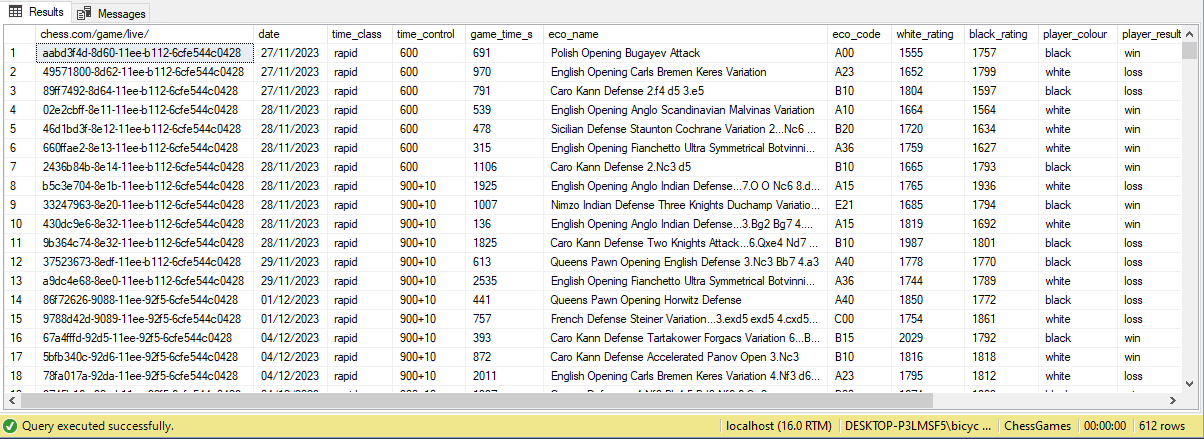

<div style="background-color: yellow; padding: 20px;">
<h1 style="color: black;">6. Ad Hoc Analysis</h1>
</div>

***
__Visualise rating over time; given chess has three distinct time controls, three graphs should be output.__
***

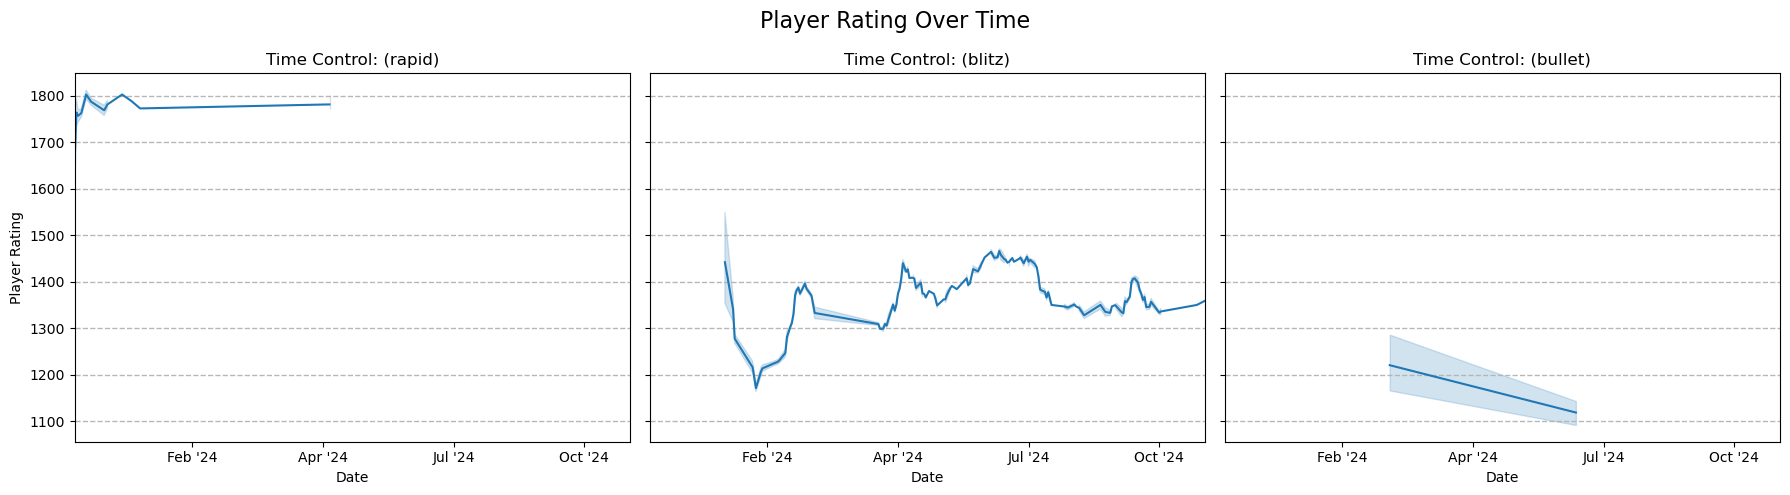

In [320]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Verify the 'date' column is datetime
data_df['date'] = pd.to_datetime(data_df['date'], format='%d/%m/%Y')

# Get the overall date range (min and max date) from the entire data_df
min_date = data_df['date'].min()
max_date = data_df['date'].max()

# Filter the dataframe by different 'time_class'
time_classes = data_df['time_class'].unique()

# Create a figure and 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Set the main title for the figure
fig.suptitle('Player Rating Over Time', fontsize=16)

# Loop through each time class and create a plot
for i, time_class in enumerate(time_classes):
    subset = data_df[data_df['time_class'] == time_class]
    sns.lineplot(data=subset, x='date', y='player_rating', ax=axes[i])
    axes[i].set_title(f'Time Control: ({time_class})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Player Rating')
    
    # Set the same x-axis limits (date range) for all graphs
    axes[i].set_xlim([min_date, max_date])

    # Set the number of ticks to 5 and format the ticks as 'May '16'
    axes[i].xaxis.set_major_locator(ticker.MaxNLocator(5))  # Set 5 ticks
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))  # Format as 'May '16'

    # Tick labels
    plt.setp(axes[i].get_xticklabels(), rotation=0)

    # Add faint gridlines parallel to the x-axis (on the y-axis)
    axes[i].grid(True, which='major', axis='y', linestyle='--', linewidth=1, alpha=0.9)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


***
__Takeaway: the player has only consistently played Blitz since their account was created. Their Blitz rating has fluctuated from about 1200 to 1500 and is generally trending upwards.__

__Identify the strongest and weakest openings (ECO Code) by win rate, for white and black, where more than 10 games have been played__
***

In [323]:
import pandas as pd

def calculate_win_rate(df, player_colour, time):
    # Filter the DataFrame based on player_colour and time control
    filtered_df = df[(df['player_colour'] == player_colour) & (df['time_class'] == time)]
    
    # Group by 'eco_code' and calculate the count of wins and total games
    win_counts_by_eco = filtered_df.groupby('eco_code').agg(
        wins=('winning_colour', lambda x: (x == player_colour).sum()),  # Count of wins for the player_colour
        total_games=('winning_colour', 'size')  # Total number of games
    ).reset_index()
    
    # Calculate the win rate and filter out rows with total games <= 10
    win_counts_filtered = win_counts_by_eco.assign(
        win_rate=lambda x: x['wins'] / x['total_games']
    ).query('total_games > 10').sort_values(by='win_rate', ascending=False)
    
    return win_counts_filtered

# Apply the function to get win rates for both player colours with time set to 'blitz'
white_win_rates = calculate_win_rate(data_df, 'white', 'blitz')
black_win_rates = calculate_win_rate(data_df, 'black', 'blitz')

# Print the results without showing the index
print("White Win Rates (Blitz):")
print(white_win_rates.to_string(index=False))

print("\nBlack Win Rates (Blitz):")
print(black_win_rates.to_string(index=False))


White Win Rates (Blitz):
eco_code  wins  total_games  win_rate
     A36    10           12  0.833333
     A18    10           14  0.714286
     A15    14           23  0.608696
     A22    26           46  0.565217
     B20    13           23  0.565217
     C00    14           25  0.560000
     A10    27           56  0.482143
     B10    12           25  0.480000
     A16    11           25  0.440000
     A25    10           24  0.416667
     A21    14           34  0.411765

Black Win Rates (Blitz):
eco_code  wins  total_games  win_rate
     B12    27           53  0.509434
     B13    37           73  0.506849
     B10    36           79  0.455696
     A40    23           65  0.353846
     B15     6           17  0.352941


C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\4018811183.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_rate', y='eco_code', data=white_win_rates, palette='ch:start=.2,rot=-.3', ax=axes[0])
C:\Users\bicyc\AppData\Local\Temp\ipykernel_25648\4018811183.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_rate', y='eco_code', data=black_win_rates, palette="ch:start=.2,rot=-.3", ax=axes[1])


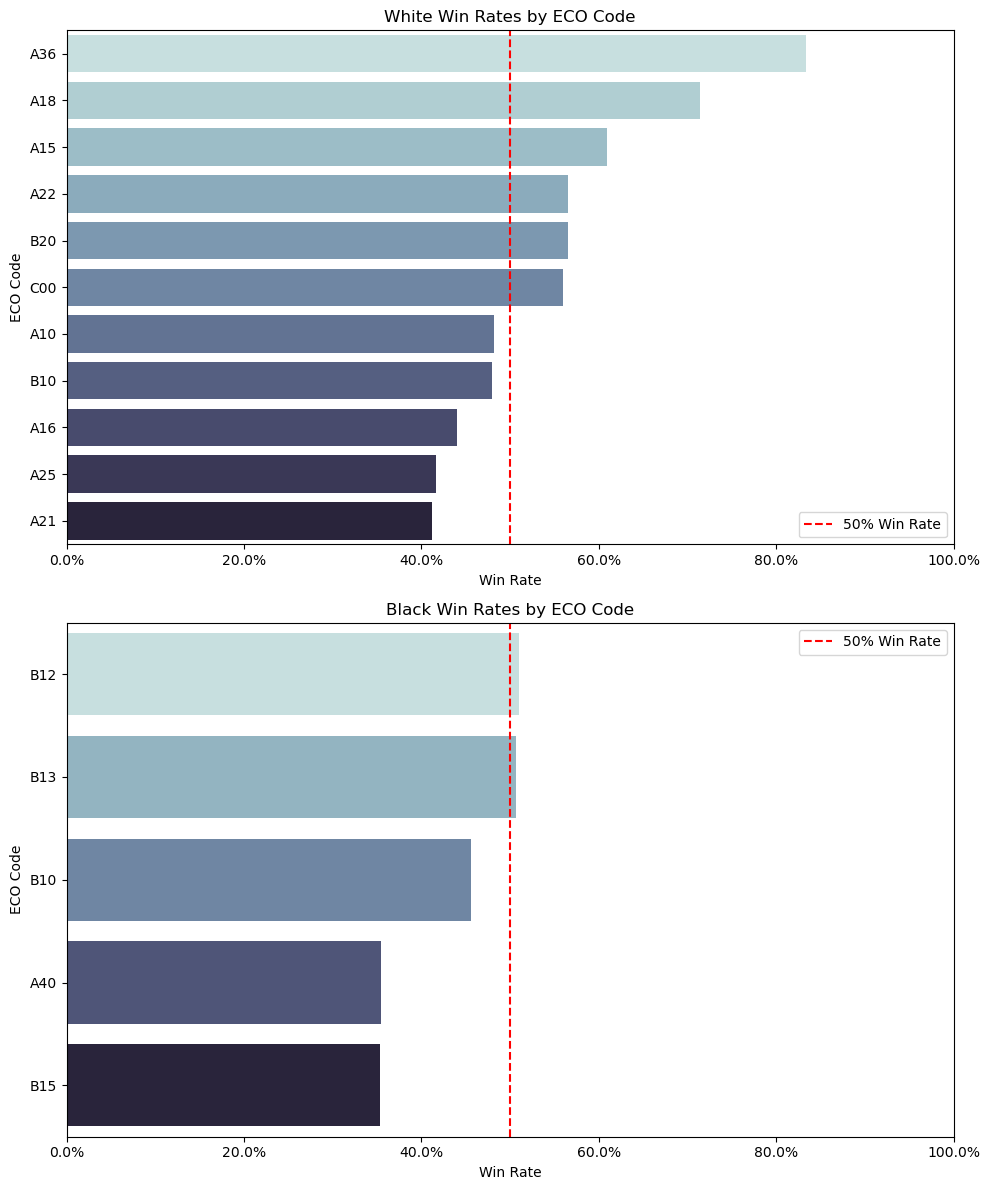

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Ensure the data is sorted by win_rate in descending order
white_win_rates = white_win_rates.sort_values(by='win_rate', ascending=False)
black_win_rates = black_win_rates.sort_values(by='win_rate', ascending=False)

# Create a figure with 2 rows, 1 column
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot White Win Rates on the first subplot
sns.barplot(x='win_rate', y='eco_code', data=white_win_rates, palette='ch:start=.2,rot=-.3', ax=axes[0])
axes[0].set_title('White Win Rates by ECO Code')
axes[0].set_xlabel('Win Rate')
axes[0].set_ylabel('ECO Code')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.1f}%'))  # Format x-axis as percentage
axes[0].set_xlim(0, 1)  # Set x-axis limit to 0-100%

# Add vertical line at 50%
axes[0].axvline(x=0.5, color='red', linestyle='--', label='50% Win Rate')
axes[0].legend()

# Plot Black Win Rates on the second subplot
sns.barplot(x='win_rate', y='eco_code', data=black_win_rates, palette="ch:start=.2,rot=-.3", ax=axes[1])
axes[1].set_title('Black Win Rates by ECO Code')
axes[1].set_xlabel('Win Rate')
axes[1].set_ylabel('ECO Code')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.1f}%'))  # Format x-axis as percentage
axes[1].set_xlim(0, 1)  # Set x-axis limit to 0-100%

# Add vertical line at 50%
axes[1].axvline(x=0.5, color='red', linestyle='--', label='50% Win Rate')
axes[1].legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()


***
__Takeaway: There is massive difference between Kuzzonz strongest and weakest openings; there is at least a 40% difference between the strongest and weakest opening as white. A good idea for future work is to normalise the white win rate and black win rate data to compensate for the fact that the 'white' player in chess has a higher win rate so this must be considered first in order to compare white openings with black openings.__
***